# 0. Imports

In [1]:
import config as creds
import pandas as pd
import sweetviz as sv
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scikitplot as skplt
import pickle

from xgboost import XGBClassifier
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors as nh
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from tabulate import tabulate

from boruta import BorutaPy
# also possible using sqlalchemy
import psycopg2


## 0.1 Helper functions

In [2]:
def connect():
    
    # set up a connection to the postgres server.
    conn_string = ("host="+ creds.PGHOST +\
                   " port="+ "5432" +\
                   " dbname="+ creds.PGDATABASE +\
                   " user=" + creds.PGUSER+ \
                   " password="+ creds.PGPASSWORD)
    
    conn = psycopg2.connect(conn_string)

    # create a cursor object
    # used to perform queries
    cursor = conn.cursor()
    
    return conn, cursor


def gain_lift_curve(yhat, yval, plot = True, size = (6,8)):
    '''
    plots gain and lift curve, respectively
    returns the curves and a table used to plot the curves
    '''

    # create table proba with the propensity score for each class (0 and 1)
    table_proba = pd.DataFrame(yhat)

    # add the 'response' column
    table_proba['target'] = yval.values

    # add the 'correct' column to evaluate wheter the prediction was right or not
    x = lambda x: "yes" if x[0] > x[1] and x['target'] == 0 else "yes" if x[1] > x[0] and x['target'] == 1 else "yes" if x[0] == x[1] else "no" 
    table_proba['correct'] = table_proba.apply(x, axis = 1)

    # order by propensity score for the class 1
    table_proba.sort_values(1, ascending = False, inplace = True)

    # create cumulative propensity score
    ## calculate the quantity of class 1 rows
    qty_class_1 = table_proba.groupby('target').count().loc[1,1]

    ## apply a score for every row which target is 1
    x = lambda x: 1/qty_class_1 if x['target'] == 1 else 0
    table_proba['propensity_score'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_propensity_score'] = np.cumsum(table_proba['propensity_score'])

    # create % cumulative of the base
    x = lambda x: 1/len(table_proba)
    table_proba['porc_base'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_porc_base'] = np.cumsum(table_proba['porc_base'])
    table_proba.drop('porc_base', axis = 1, inplace = True)

    # create the lift column
    table_proba['lift'] = table_proba['cumulative_propensity_score'] / table_proba['cumulative_porc_base']

    if plot:
        fig, axes = plt.subplots(2, 1, figsize=size)

        # gap between graphics
        fig.tight_layout(pad =5)

        # gain curve
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_propensity_score'], label="cumulative (model)", linewidth = 2.5);
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_porc_base'], label="baseline", linewidth = 2.5, color = 'black' )
        axes[0].lines[1].set_linestyle("--")
        axes[0].legend()
        axes[0].set_title("cumulative gains curve")
        axes[0].set_xlabel("percentage of sample")
        axes[0].set_ylabel("gain")

        # lift curve
        ## do not consider the beginning of the series, as it varies a lot (the sample is still small)
        table_proba_filtered = table_proba.query('cumulative_porc_base >= 0.1')

        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = table_proba_filtered['lift'], label="model", linewidth = 2.5 );
        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = np.ones(len(table_proba_filtered)), label="baseline", linewidth = 2.5, color = 'black' )
        axes[1].lines[1].set_linestyle("--")
        axes[1].legend()
        axes[1].set_title("lift curve")
        axes[1].set_xlabel("percentage of sample")

        plt.show();
        
    return (table_proba)



def precision_recall_at_k(table, k = 2000):
    ''' 
    receives the table that was generated in gain_lift_curve function and returns: 
    - a tuple containg the precision at k and recall at k, respectively
    - a new table with precision_at_k and recall_at_k metrics 
    '''
    table.reset_index(drop=True, inplace = True)
    table['ranking'] = table.index + 1 # as the index starts in 0 it is necessary to +1
    table['precision_at_k'] = table['target'].cumsum() / table['ranking']
    table['recall_at_k'] = table['target'].cumsum() / table['target'].sum()
    return ((table.loc[k-1, 'precision_at_k'], table.loc[k-1, 'recall_at_k']),table) # as the loc uses index, it is necessary to -1 to return the desired k




def compiled_precision_recall(list_of_dfs):
    dict_precision = {'Precision@': ['10% (3049)', '20% (6098)', '30% (9147)', '40% (12196)']}
    dict_recall = {'Recall@': ['10% (3049)', '20% (6098)', '30% (9147)', '40% (12196)']}
    
    for model in list_of_dfs:
        
        metrics10, _ = precision_recall_at_k(eval(model),3049)
        metrics20, _ = precision_recall_at_k(eval(model),6098)
        metrics30, _ = precision_recall_at_k(eval(model),9147)
        metrics40, _ = precision_recall_at_k(eval(model),12196)
        
        dict_precision[model] = [round(metrics10[0], 2),
                                 round(metrics20[0], 2),
                                 round(metrics30[0], 2), 
                                 round(metrics40[0], 2)]

        dict_recall[model] = [round(metrics10[1], 2), 
                              round(metrics20[1], 2),
                              round(metrics30[1], 2), 
                              round(metrics40[1], 2)]
        
    df_precision = pd.DataFrame(dict_precision).set_index('Precision@')
    df_recall = pd.DataFrame(dict_recall).set_index('Recall@')
    
    df_precision.columns = ['k-nearest neighbors',
                            'logistic regression',
                            'random forest classifier',
                            'balanced random forest classifier',
                            'xgboost classifier', 
                            'perfect model' ]
     
    df_recall.columns = ['k-nearest neighbors',
                         'logistic regression',
                         'random forest classifier',
                         'balanced random forest classifier',
                         'xgboost classifier', 
                         'perfect model' ]
    
    return (df_precision, df_recall)   


# 1.0 Schema query

In [3]:
# connecting to DB
conn, cursor = connect()

# nspname: name of the namespace
# pg_namespace: system catalogue table containing schema definitions

query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

cursor.execute(query_schema)
record = (cursor.fetchall())
print(record)
cursor.close()
conn.close()

[('pg_toast',), ('pg_temp_1',), ('pg_toast_temp_1',), ('pg_catalog',), ('information_schema',), ('public',), ('pa004',), ('pg_temp_4',), ('pg_toast_temp_4',), ('pa005',), ('pg_temp_9',), ('pg_toast_temp_9',)]


# 2. Table query

In [4]:
#connecting to DB
conn, cursor = connect()

query_tables = """
    SELECT tablename
    FROM pg_tables
    WHERE schemaname ='pa004'
"""

cursor.execute(query_tables)
record = (cursor.fetchall())
print(record)
cursor.close()
conn.close()

[('users',), ('vehicle',), ('insurance',)]


# 3. Collect data

## 3.1 Using psycopg2

In [5]:
# connecting to DB
conn, cursor = connect()

# the 'age > 44' is just an example to make the query faster
query_tables_users = """
    SELECT *
    FROM pa004.users u
    WHERE age > 44
"""

cursor.execute(query_tables_users)
record = (cursor.fetchall())
cursor.close()
conn.close()

# not good because it is necessary to enter columns names manually
# to improve this, we can make data collection using pandas
pd.DataFrame(record).head()

,0,1,2,3,4
0,2,Male,76,3.0,26.0
1,3,Male,47,28.0,26.0
2,8,Female,56,28.0,26.0
3,11,Female,47,35.0,124.0
4,14,Male,76,28.0,13.0


## 3.2 Using pandas.io.sql

In [6]:
import pandas.io.sql as psql

In [7]:
conn, cursor = connect()

query_tables_users = """
    SELECT *
    FROM pa004.users u
"""

# the columns names are obtained when using pandas to collect data
display(psql.read_sql(query_tables_users, conn).head())

cursor.close()
conn.close()


,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0


## 3.3 Using only pandas

In [8]:
conn, cursor = connect()

query_tables_users = """
    SELECT *
    FROM pa004.users u
"""

# the columns names are obtained when using pandas to collect data
display(pd.read_sql(query_tables_users, conn).head())

cursor.close()
conn.close()

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0


## 3.4 Join all the tables

In [9]:
conn, cursor = connect()

query_tables_users = """
    SELECT *
    FROM pa004.users u inner join pa004.vehicle v on(u.id=v.id)
                       inner join pa004.insurance i on(u.id = i.id)
"""

# the columns names are obtained when using pandas to collect data
df_raw = pd.read_sql(query_tables_users, conn)

cursor.close()
conn.close()

In [10]:
# remove duplicate columns (i.e. the 'id' from vehicle and insurance tables)
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]
df_raw

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381070,Male,24,8.0,152.0,1,< 1 Year,No,1,38254.0,127,0
381105,381079,Female,58,28.0,26.0,1,1-2 Year,Yes,0,39740.0,170,0
381106,381082,Female,75,28.0,26.0,1,1-2 Year,No,1,51619.0,80,0
381107,381097,Female,49,10.0,26.0,1,1-2 Year,Yes,0,34541.0,44,0


PS: database also available at https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction

In [11]:
# save the raw data
df_raw.to_pickle(r"../data/interim/df_raw.pkl")

# 4. Data description

In [12]:
# load the data
df1 = pd.read_pickle(r"../data/interim/df_raw.pkl")

## 4.1 Data dimension

In [13]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of columns: 12


## 4.2 Data types

In [14]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

All types seems correct.

## 4.3 Check NA

In [15]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

No nan values.

## 4.4 Data descriptive

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

In [17]:
# central tendency (mean, median)
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).round(2).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).round(2).T

# dispersion - std, min, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).round(2).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T

x = lambda x: x.max() - x.min()
d4 = pd.DataFrame(num_attributes.apply(x)).T

x = lambda x: x.skew().round(2)
d5 = pd.DataFrame(num_attributes.apply(x)).T

x = lambda x: x.kurtosis().round(2)
d6 = pd.DataFrame(num_attributes.apply(x)).T

# concat
data_descriptive_num = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
data_descriptive_num.columns = ['attributes', 'min','max', 'range', 'mean','median', 'std', 'skew','kurtosis']
data_descriptive_num

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.00,190555.0,110016.69,-0.00,-1.20
1,age,20.0,85.0,65.0,38.82,36.0,15.51,0.67,-0.57
2,region_code,0.0,52.0,52.0,26.39,28.0,13.23,-0.12,-0.87
3,policy_sales_channel,1.0,163.0,162.0,112.03,133.0,54.20,-0.90,-0.97
4,driving_license,0.0,1.0,1.0,1.00,1.0,0.05,-21.60,464.35
5,previously_insured,0.0,1.0,1.0,0.46,0.0,0.50,0.17,-1.97
6,annual_premium,2630.0,540165.0,537535.0,30564.39,31669.0,17213.13,1.77,34.00
7,vintage,10.0,299.0,289.0,154.35,154.0,83.67,0.00,-1.20
8,response,0.0,1.0,1.0,0.12,0.0,0.33,2.30,3.30


# 5. Test data extraction

In [18]:
X = df1.drop('response', axis = 1).copy()
y = df1['response'].copy()
x_train, x_test, y_train, y_test = ms.train_test_split(X,y, stratify = y, test_size=0.20, random_state = 45263)

# df2 is the new database (that will be used to train and validate the models)
df2 = pd.concat([x_train, y_train], axis = 1)


# df_test is a separate database only used to perfomr the final evaluation of the trained model
#df_test = pd.concat([x_test, y_test], axis = 1)

In [19]:
x_train.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
dtype: int64

In [20]:
x_test.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
dtype: int64

# 6. Feature engineering

In [21]:
# vehicle age
dict_vehicle_age = {'> 2 Years':'over_2_years', '1-2 Year':'between_1_2_year', '< 1 Year':'below_1_year'}
df2['vehicle_age'] = df2['vehicle_age'].map(dict_vehicle_age)

# vehicle damage
dict_vehicle_damage = {'Yes': 1, 'No': 0}
df2['vehicle_damage'] = df2['vehicle_damage'].map(dict_vehicle_damage)
df2

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
67177,155820,Female,24,25.0,152.0,1,below_1_year,0,1,30719.0,36,0
23918,191003,Female,25,40.0,156.0,1,between_1_2_year,1,1,2630.0,140,0
212568,173432,Male,25,8.0,152.0,1,below_1_year,0,1,44743.0,218,0
45341,361654,Male,41,41.0,124.0,1,between_1_2_year,1,0,2630.0,146,0
163500,162403,Female,21,36.0,160.0,1,below_1_year,0,0,45281.0,253,0
...,...,...,...,...,...,...,...,...,...,...,...,...
148211,41755,Male,43,47.0,124.0,1,between_1_2_year,0,1,37527.0,86,0
122746,217884,Male,26,28.0,152.0,1,below_1_year,0,1,67413.0,184,0
276435,304039,Female,21,25.0,152.0,1,below_1_year,1,0,37562.0,133,1
315657,236087,Male,23,29.0,152.0,1,below_1_year,0,1,28228.0,290,0


# 7. Data filtering

In [22]:
# save the new database
df2.to_pickle(r"../data/interim/df2.pkl")

df3 = pd.read_pickle(r"../data/interim/df2.pkl")

After analyzing data_descriptive_num, no conditions necessary to apply a filter were verified. There is no apparently outlier data that needs to be removed.

# 8. EDA with SweetViz

In [23]:
df4 = df3.copy()
report = sv.analyze(df4, target_feat='response')
report.show_html(filepath='../reports/SWEETVIZ_REPORT.html',open_browser=False)

                                             |     | [  0%]   00:00 -> (? left)

Report ../reports/SWEETVIZ_REPORT.html was generated.



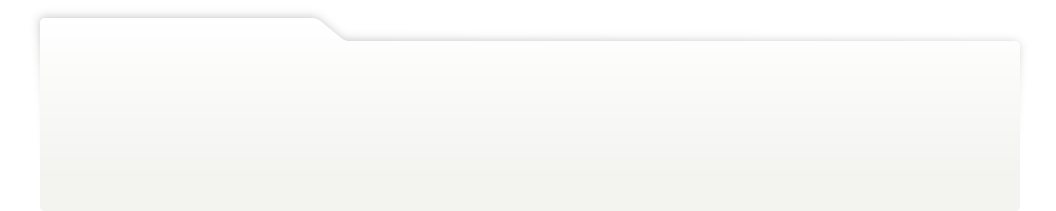
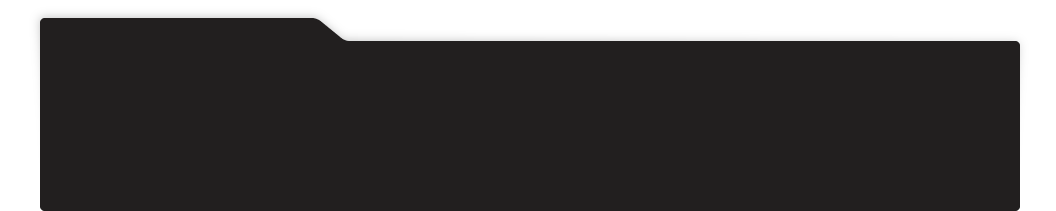
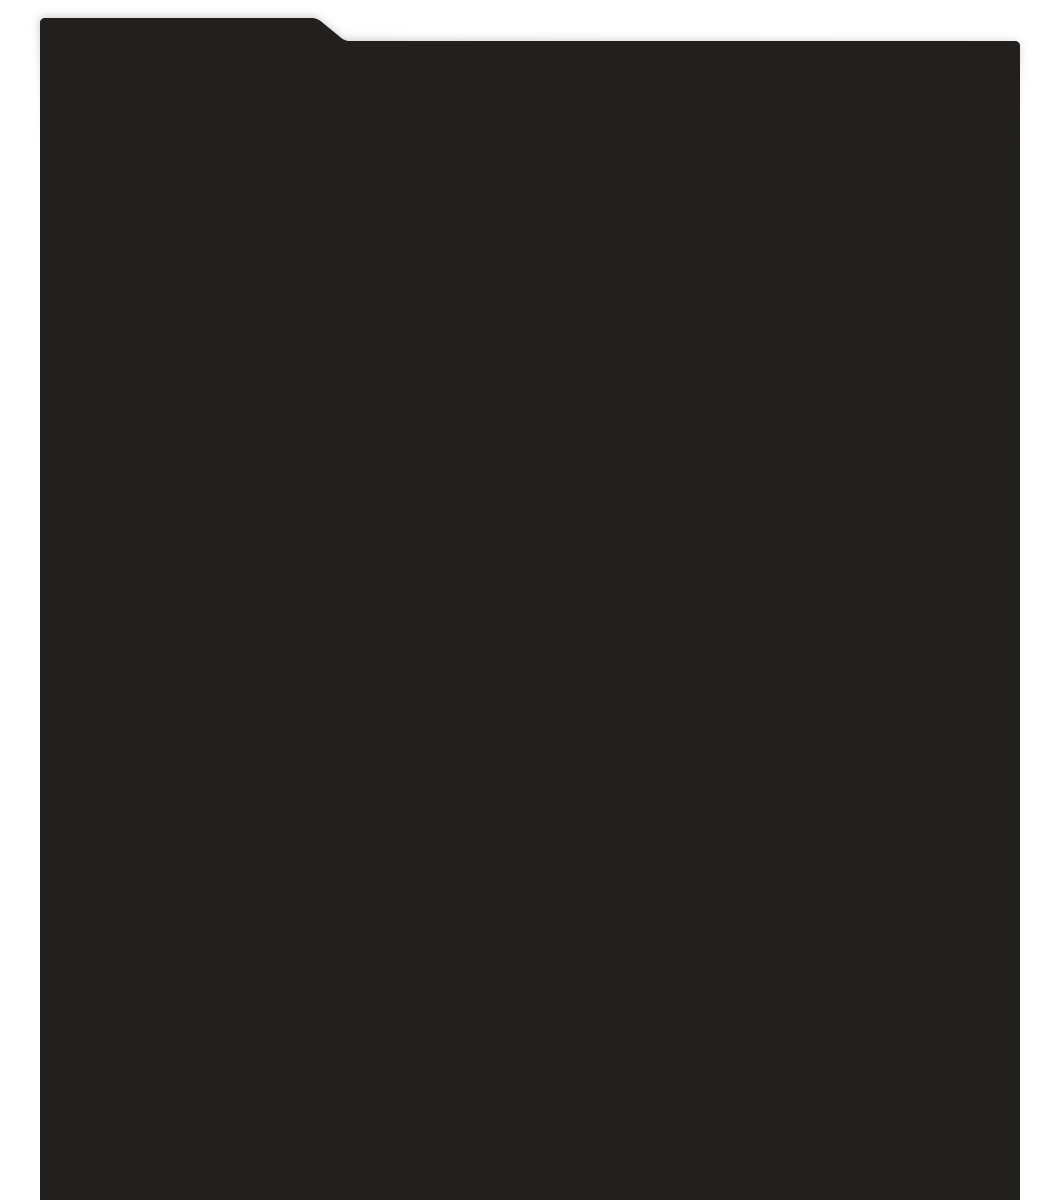
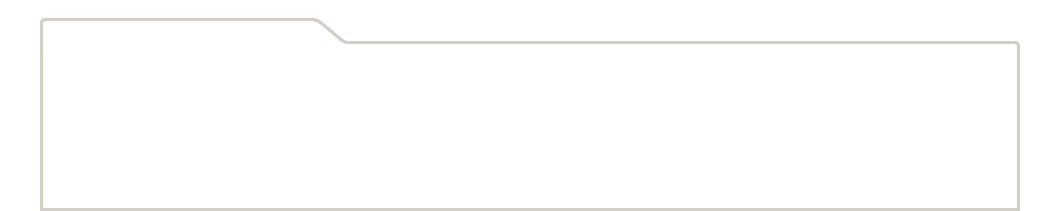
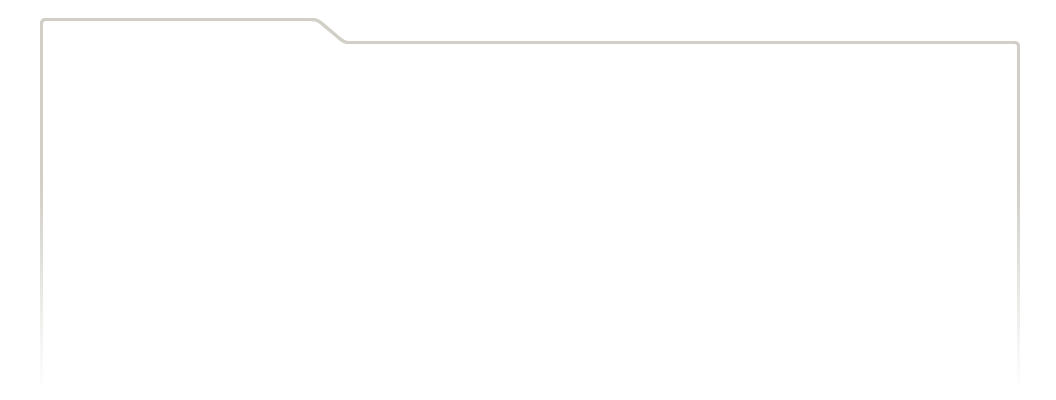
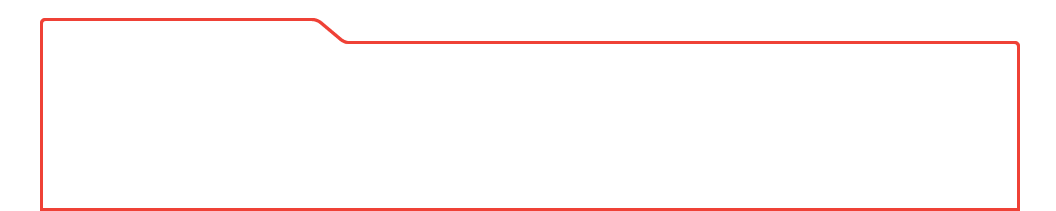
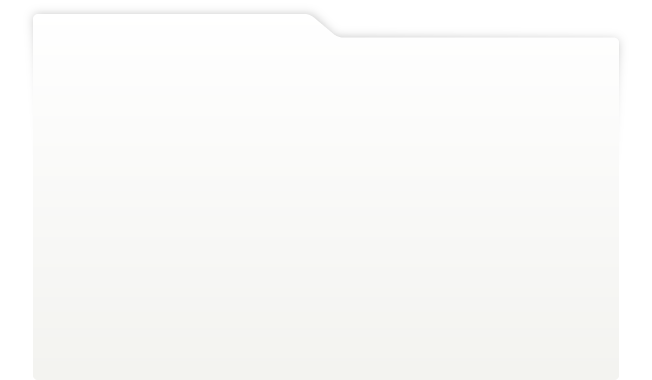
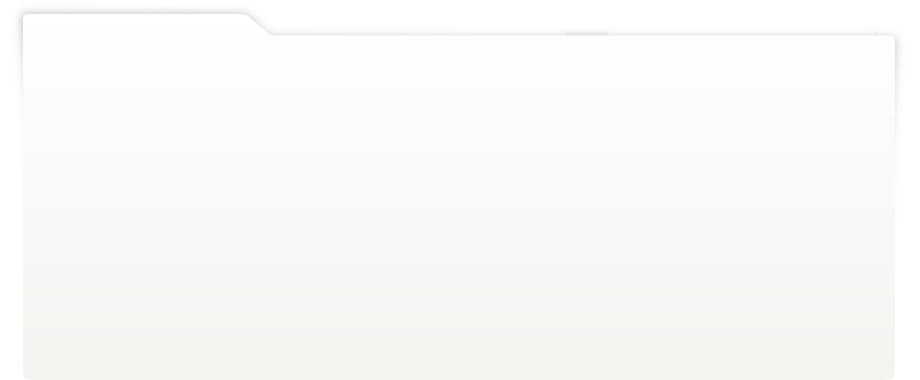
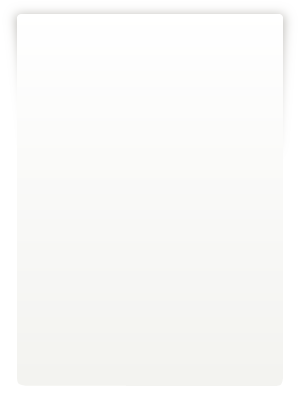
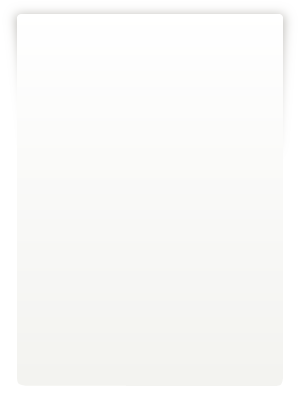
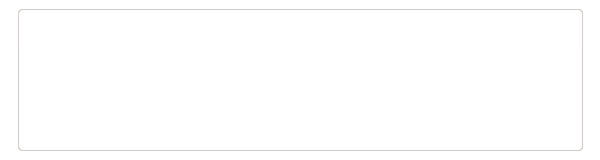
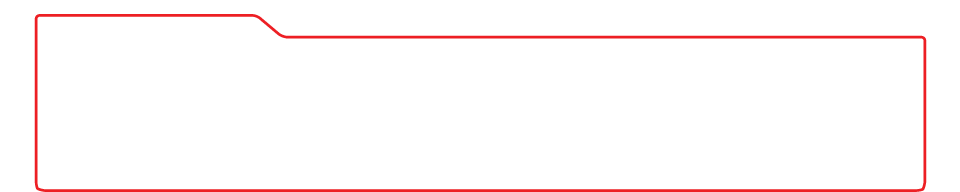
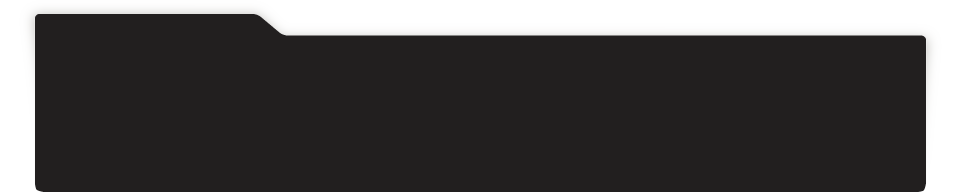
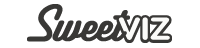
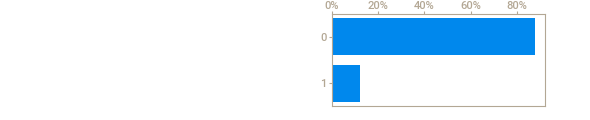
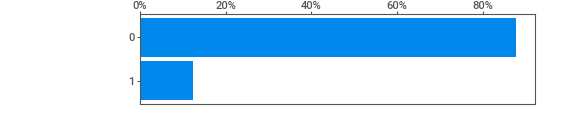
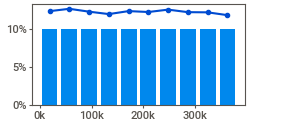
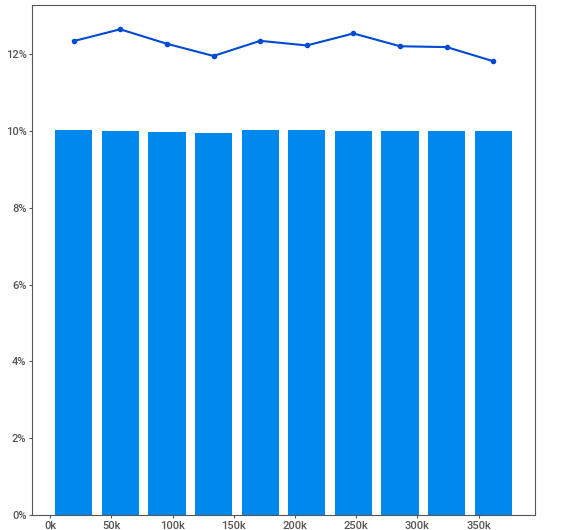
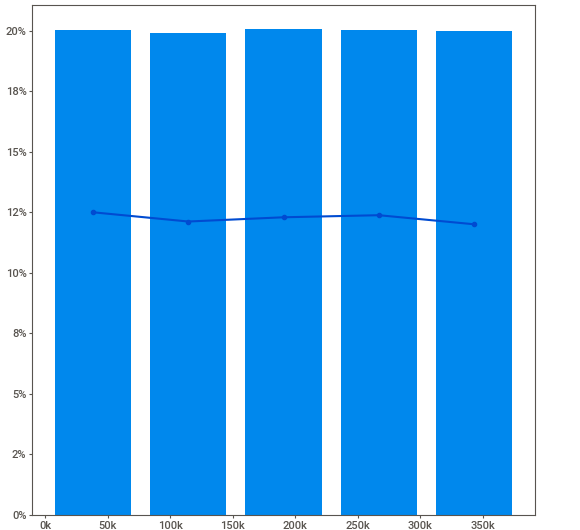
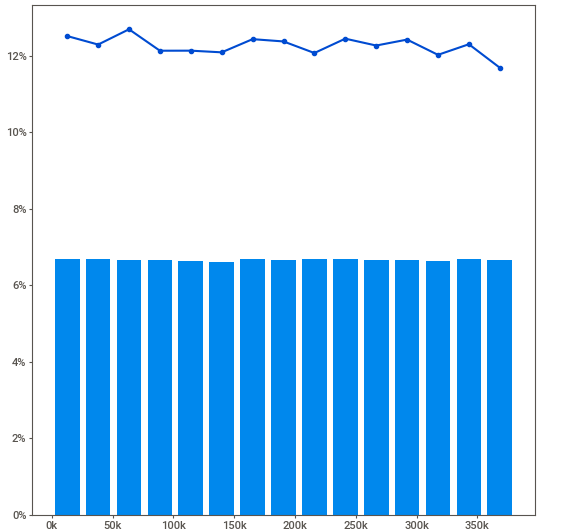
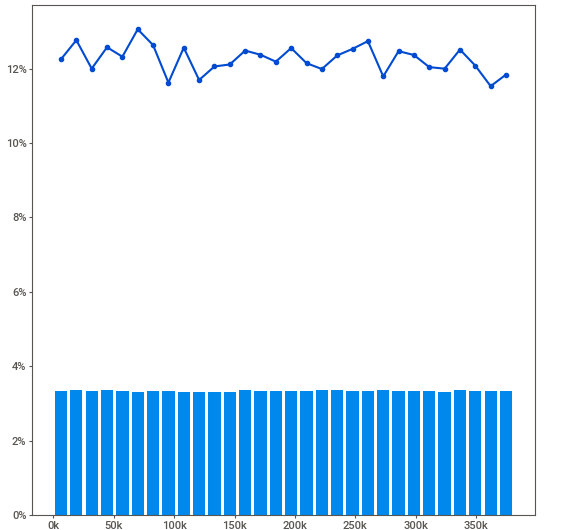
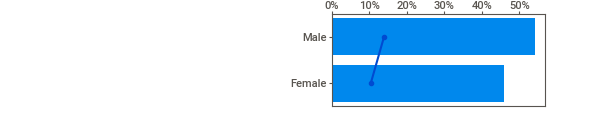
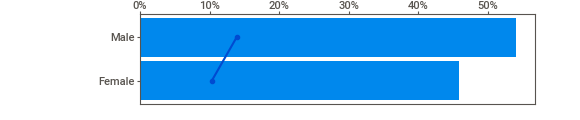
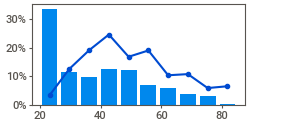
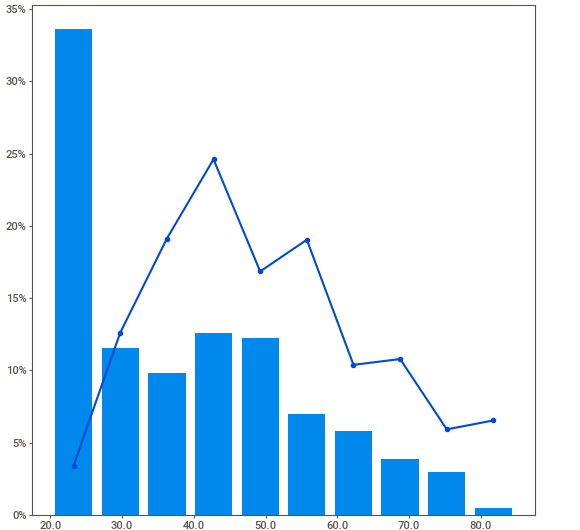
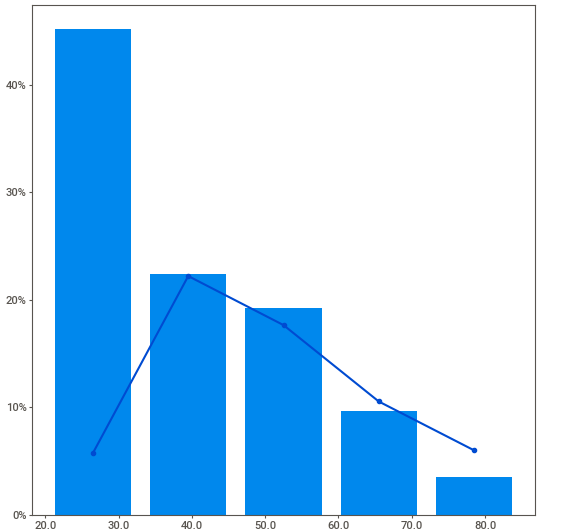
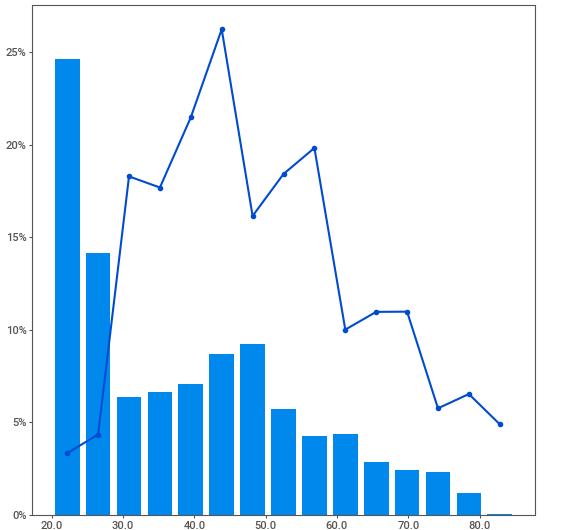
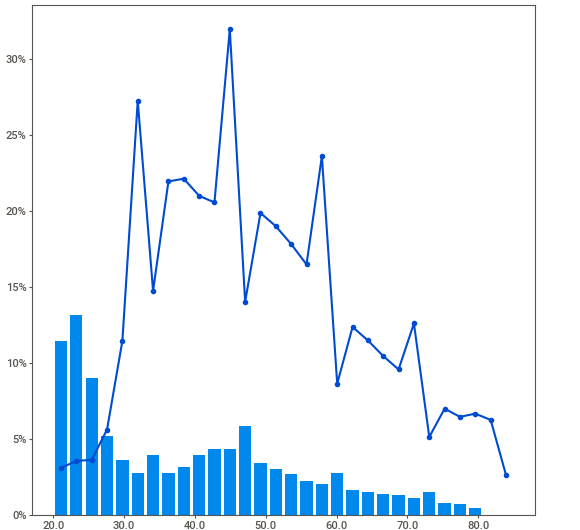
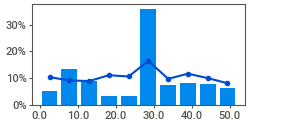
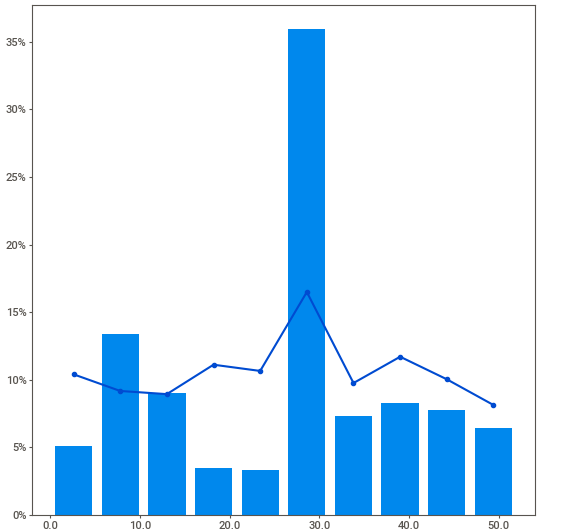
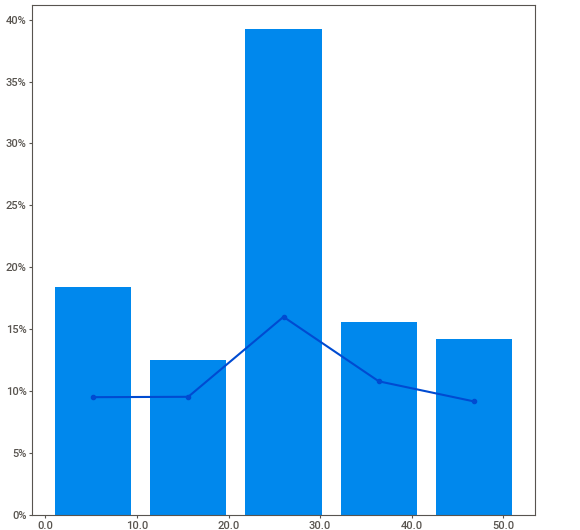
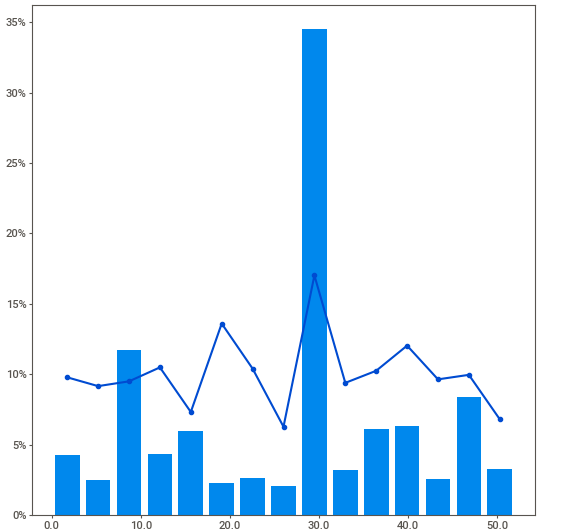
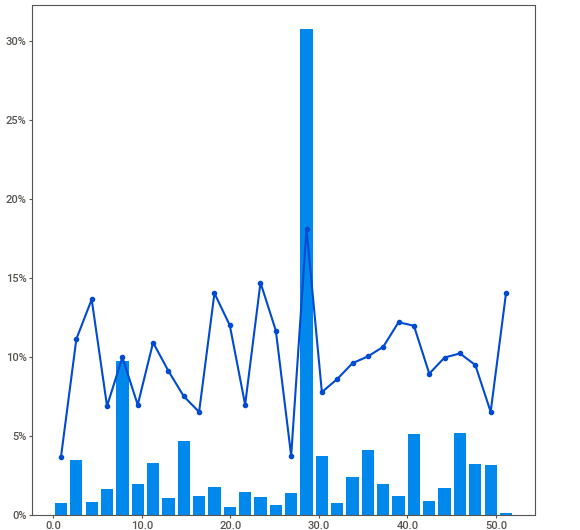
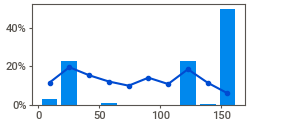
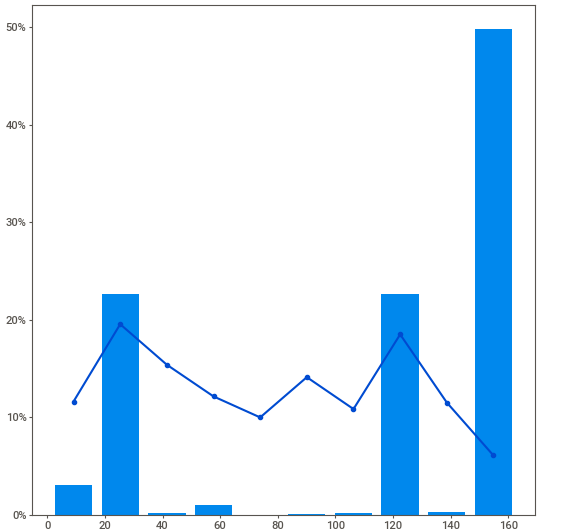
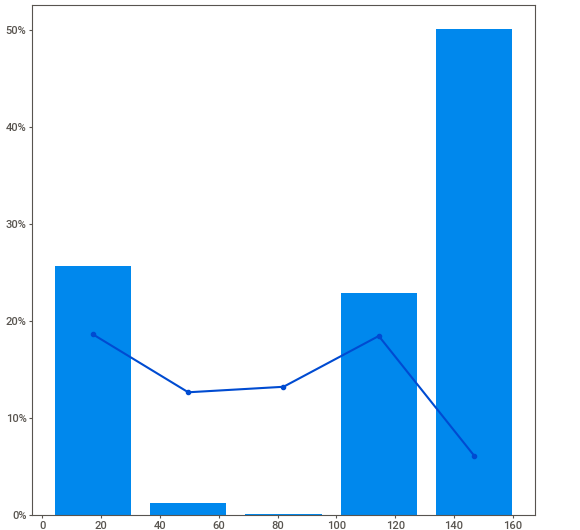
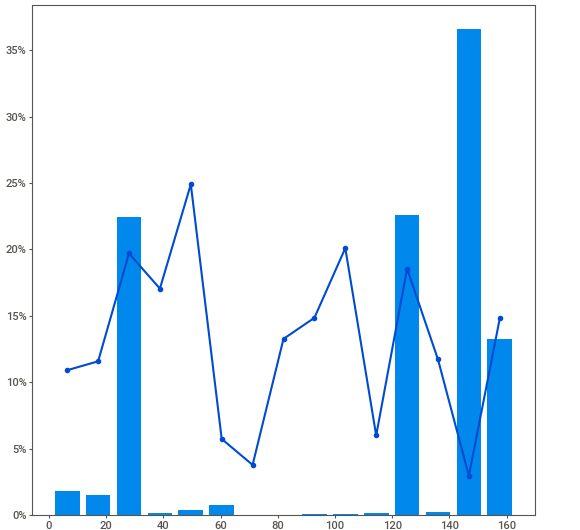
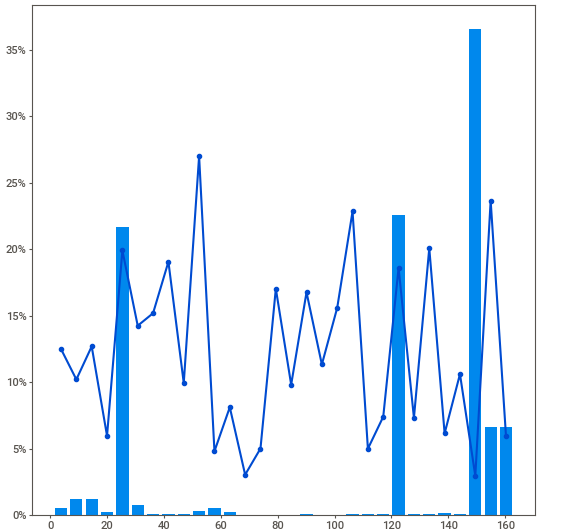
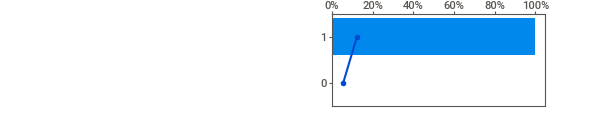
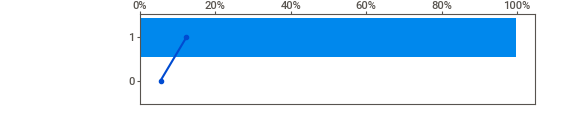
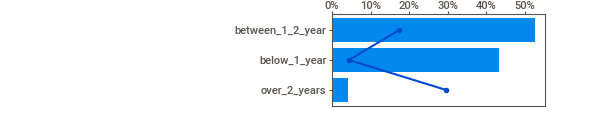
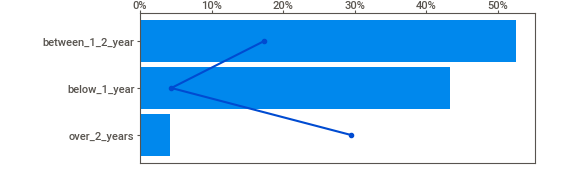
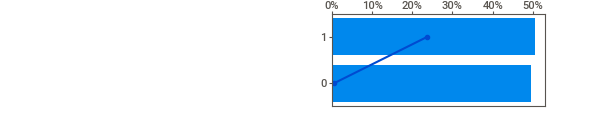
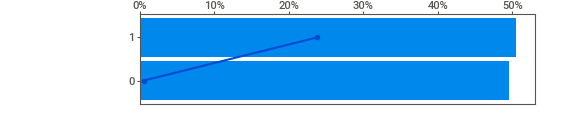
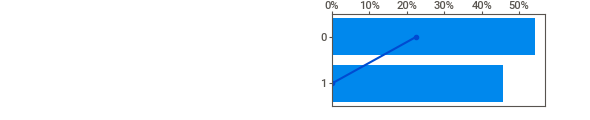
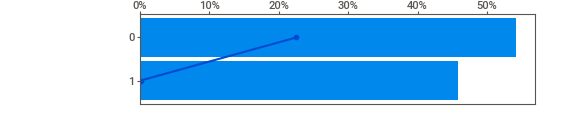
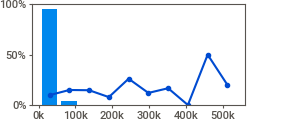
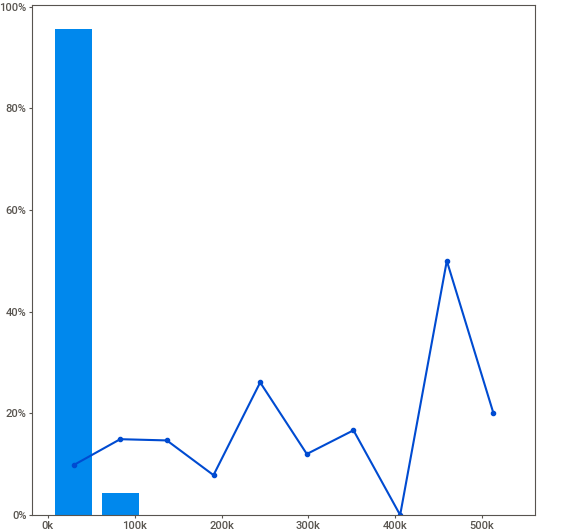
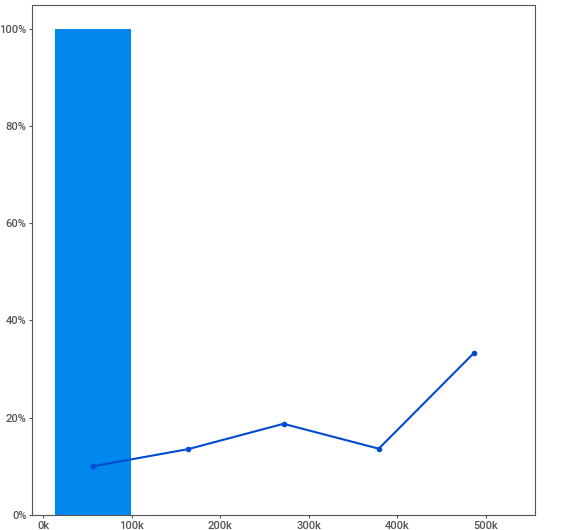
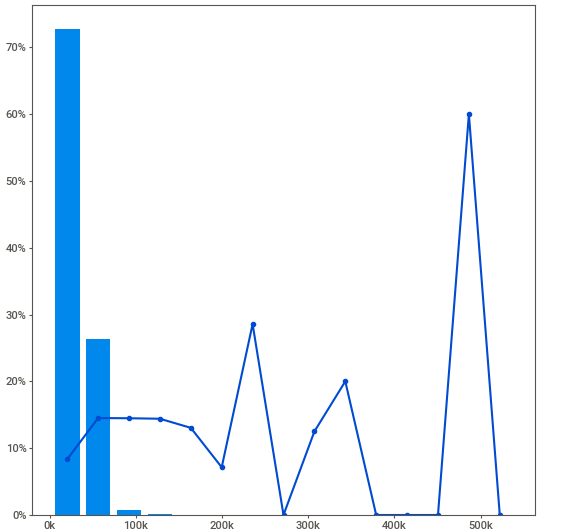
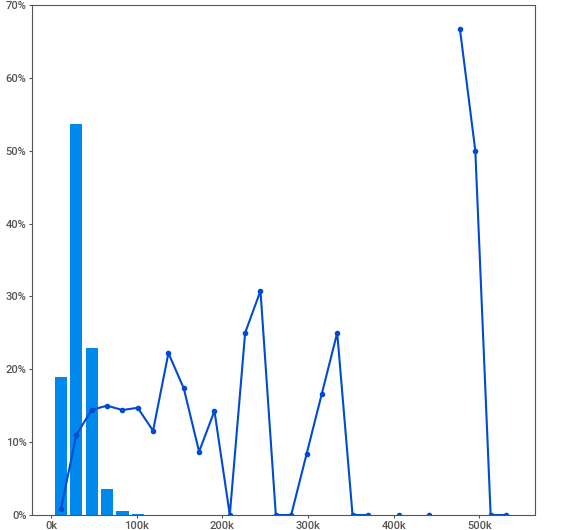
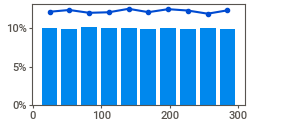
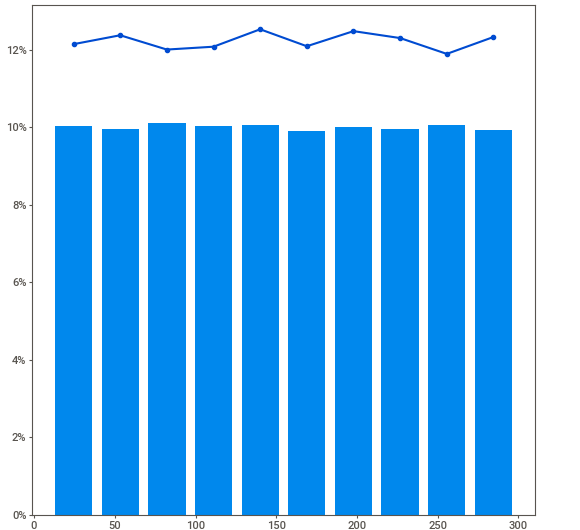
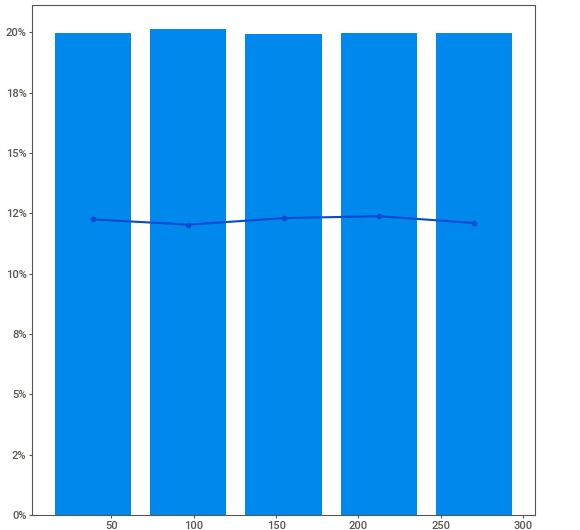
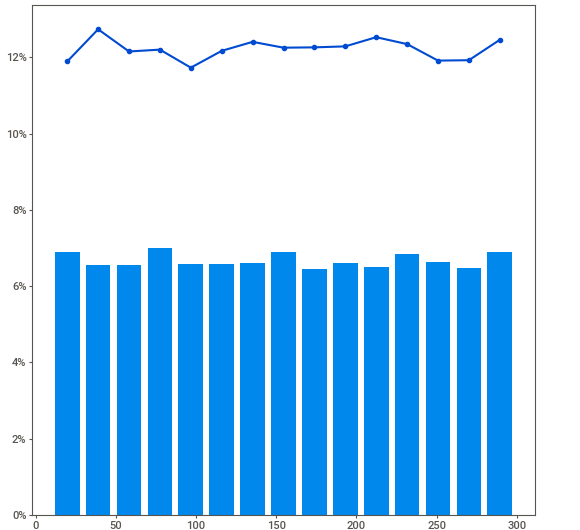
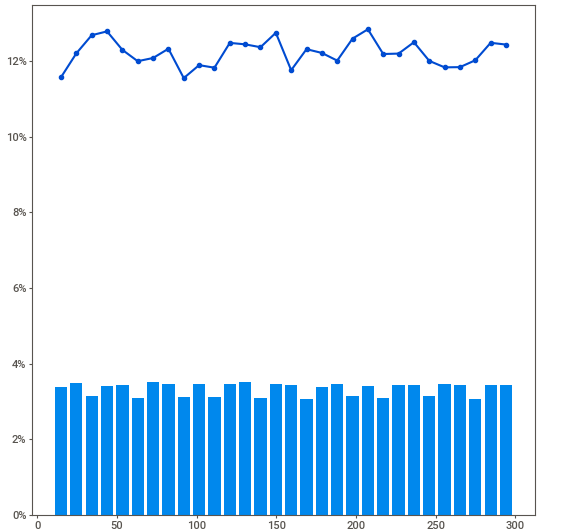
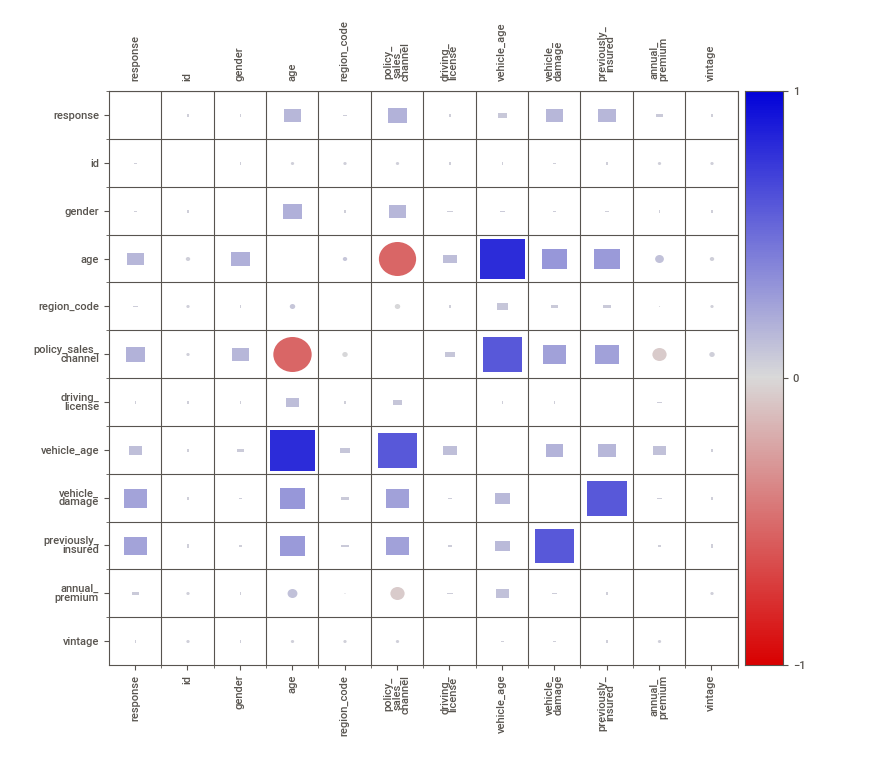
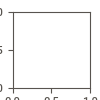

In [24]:
# display on the nb
report.show_notebook(w=None, h=None,scale=None,layout='vertical')

## 8.1 Considerations from EDA

- The number of people interested in vehicle insurance is much smaller compared to people not interested (12% vs 88%)

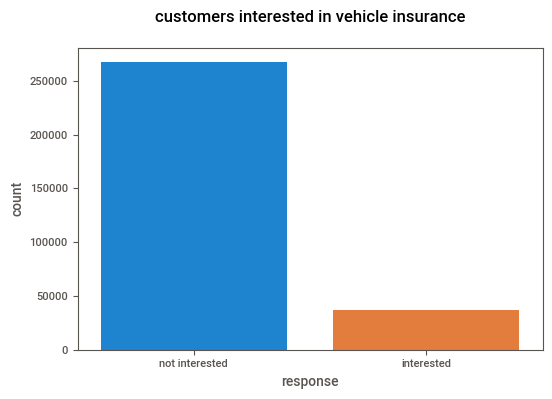

In [25]:
ax = sns.countplot(x = 'response', data = df4)
ax.set_xticklabels(['not interested', 'interested']);
ax.set_title('customers interested in vehicle insurance\n');

- People between 35-45 years old are the most interested in vehicle insurance

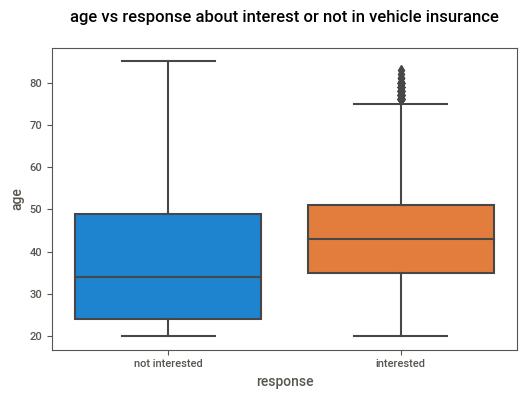

In [26]:
ax = sns.boxplot(x = 'response', y= 'age', data = df4)
ax.set_xticklabels(['not interested', 'interested']);
ax.set_title('age vs response about interest or not in vehicle insurance\n');

- The distribution of the annual premium is similar between interested and non-interested customers.

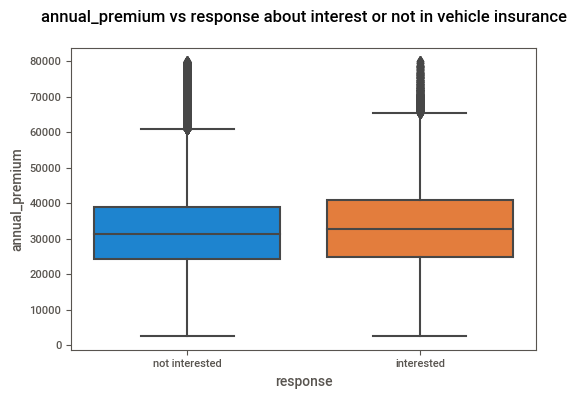

In [27]:
# '<80000' is to remove outliers
ax = sns.boxplot(x = 'response', y= 'annual_premium', data = df4[df4['annual_premium'] < 80000])
ax.set_xticklabels(['not interested', 'interested'])
ax.set_title('annual_premium vs response about interest or not in vehicle insurance\n');

- Region 28 contains most part of the customers and also most percentage of people interested in vehicle insurance

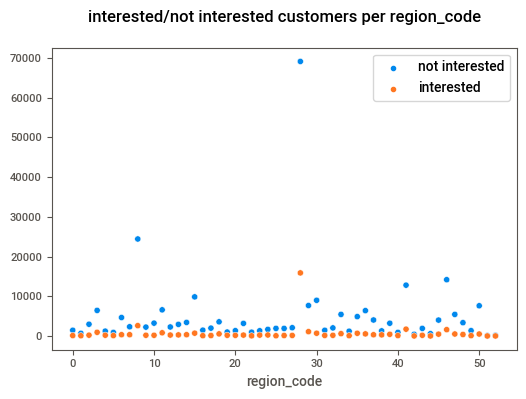

In [28]:
aux = df4[['region_code', 'id', 'response']].groupby(['region_code', 'response']).count().reset_index()
aux['response'] = aux['response'].map({0:'not interested', 1:'interested'})
ax = sns.scatterplot(x='region_code', y = 'id', hue = 'response', data = aux, s=20)
ax.set_title('interested/not interested customers per region_code\n')
ax.legend(title='')
ax.set_ylabel('');

- If a customer already have vehicle insurance the chances of being interested in insurance are minimal.

In [29]:
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: round((x/x.sum())*100, 2), axis = 1)

response,0,1
previously_insured,,
0,77.47,22.53
1,99.91,0.09


- The older the car, the more interest its owner have in acquiring vehicle insurance.

In [30]:
pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: round((x/x.sum())*100, 2), axis = 1)

response,0,1
vehicle_age,,
below_1_year,95.62,4.38
between_1_2_year,82.64,17.36
over_2_years,70.51,29.49


- The channel of outreaching to the customer 152 is the one that more contributes to the adhesion of customers, which does not mean that it is the communication channel that deals with the most interested customers.

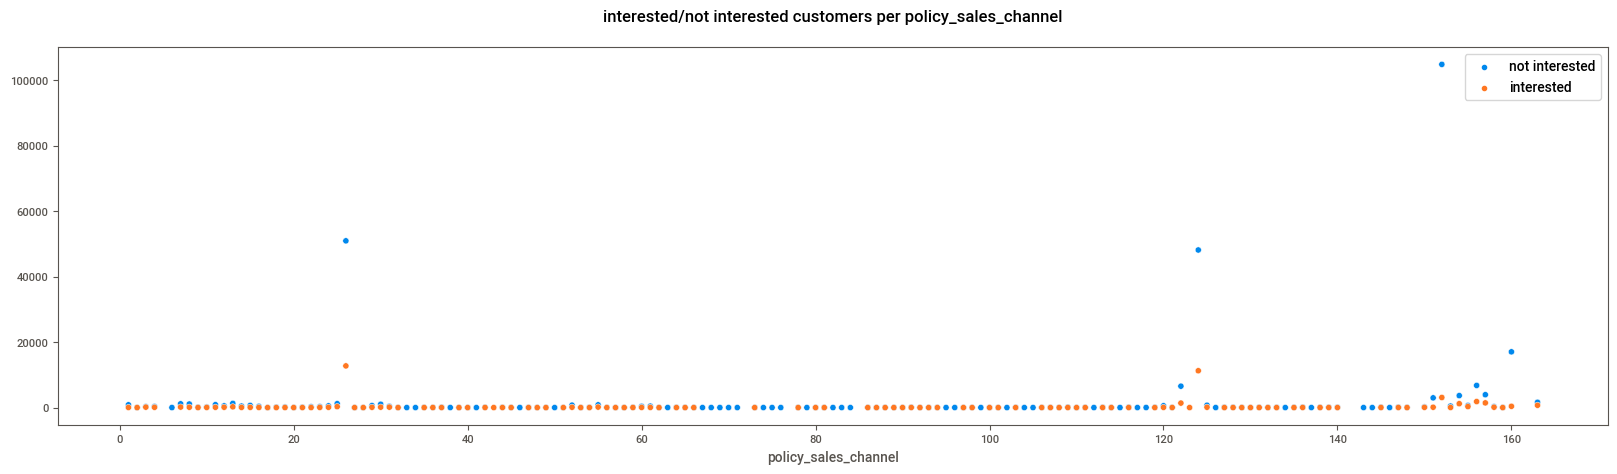

In [31]:
aux = df4[['policy_sales_channel', 'id', 'response']].groupby(['policy_sales_channel', 'response']).count().reset_index()
aux['response'] = aux['response'].map({0:'not interested', 1:'interested'})
plt.figure(figsize=(20,5))
ax = sns.scatterplot(x='policy_sales_channel', y = 'id', hue = 'response', data = aux, s=20)
ax.set_title('interested/not interested customers per policy_sales_channel\n')
ax.legend(title='')
ax.set_ylabel('');

- The vintage is similar between interested and non-interested customers.

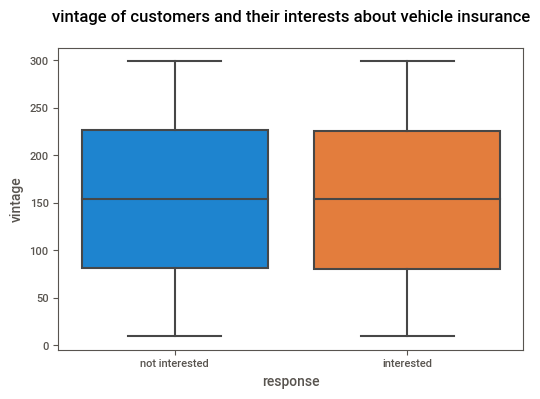

In [32]:
ax = sns.boxplot(x = 'response', y= 'vintage', data = df4)
ax.set_xticklabels(['not interested', 'interested']);
ax.set_title('vintage of customers and their interests about vehicle insurance\n');

- If a customer didn't get his/her vehicle damaged in the past the chances of being interested in insurance are minimal

In [33]:
pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: round((x/x.sum())*100, 2), axis = 1)

response,0,1
vehicle_damage,,
0,99.48,0.52
1,76.24,23.76


# 9. Data preparation

In [34]:
# save the new database
df4.to_pickle(r"../data/interim/df4.pkl")



In [35]:
df5 = pd.read_pickle(r"../data/interim/df4.pkl")

## 9.1 Standardization

In [36]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open(r'../src/features/annual_premium_scaler.pkl', 'wb'))

## 9.2 Rescaling

In [37]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open(r'../src/features/age_scaler.pkl', 'wb'))

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open(r'../src/features/vintage_scaler.pkl', 'wb'))

## 9.3 Encoder

In [38]:
# region_code: frequency encoding /target encoding / weighted target encoding
# to future CRIPS cycles, it can be used any "anti-leakage" mechanisms like regularization
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:,'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open(r'../src/features/target_encode_region_code_scaler.pkl', 'wb'))

# vehicle_age: one hot encoding / order encoding / frequency encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns = ['vehicle_age'])

# policy_sales_channel: target encoding / frequency encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open(r'../src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))

# gender: one hot encoding / target encoding
df5 = pd.get_dummies(df5, prefix='gender', columns = ['gender'])


## 9.4 Test preparation

In [39]:
# vehicle damage
x_test['vehicle_damage'] = x_test['vehicle_damage'].map(dict_vehicle_damage)

# annual_premium
x_test['annual_premium'] = ss.transform(x_test[['annual_premium']].values)

# age
x_test['age'] = mms_age.transform(x_test[['age']].values)

# vintage
x_test['vintage'] = mms_vintage.transform(x_test[['vintage']].values)

# region_code
x_test['region_code'] = x_test['region_code'].map(target_encode_region_code)

# vehicle_age
x_test['vehicle_age'] = x_test['vehicle_age'].map(dict_vehicle_age)
x_test = pd.get_dummies(x_test, prefix='vehicle_age', columns = ['vehicle_age'])

# policy_sales_channel
x_test.loc[:,'policy_sales_channel'] = x_test['policy_sales_channel'].map(fe_policy_sales_channel)

# gender
x_test = pd.get_dummies(x_test, prefix='gender', columns = ['gender'])

# drop 'id'
x_test = x_test.drop('id', axis=1)


In [40]:
# check if preparation went well
print('Check NA:\n')
display(x_test.isna().sum())
print('\n\nTest set after encoding:\n')
display(x_test.head())

Check NA:



age                             0
region_code                     0
policy_sales_channel            1
driving_license                 0
vehicle_damage                  0
previously_insured              0
annual_premium                  0
vintage                         0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
vehicle_age_over_2_years        0
gender_Female                   0
gender_Male                     0
dtype: int64



Test set after encoding:



,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,gender_Female,gender_Male
371453,0.076923,0.079443,0.353751,1,0,1,0.042900,0.512111,1,0,0,1,0
253947,0.061538,0.079443,0.353751,1,0,1,0.029545,0.000000,1,0,0,1,0
255291,0.569231,0.063459,0.003867,1,1,1,0.273994,0.619377,0,1,0,0,1
243357,0.415385,0.100308,0.194672,1,1,0,-1.620806,0.837370,0,1,0,0,1
103101,0.538462,0.187013,0.194672,1,1,0,0.896439,0.166090,0,1,0,1,0


after applying the encoders 1 row of the feature now is "NAN"; we will just drop it.

In [41]:
x_test[x_test['policy_sales_channel'].isna()].index

Int64Index([75478], dtype='int64')

In [42]:
x_test = x_test.drop(index = 75478)
y_test = y_test.drop(index = 75478)

In [43]:
display(x_test.isna().sum())

age                             0
region_code                     0
policy_sales_channel            0
driving_license                 0
vehicle_damage                  0
previously_insured              0
annual_premium                  0
vintage                         0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
vehicle_age_over_2_years        0
gender_Female                   0
gender_Male                     0
dtype: int64

Now it is all set with the test database.

# 10. Feature selection (using Boruta)

(after running the script once, it is not necessary to run it again - the processing time is long and the result obtained is always the same)

In [44]:
# perform a new data split (using only the training set, which now is df5)
X = df5.drop(['response', 'id'], axis = 1).copy()
y = df5['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X,y, stratify = y, test_size=0.10, random_state = 45263)

In [45]:
## training and test dataset for Boruta
#x_train_n = x_train.values
#y_train_n = y_train.values.ravel()

## define RandomForestRegressor
#rf = RandomForestClassifier(n_jobs=-1, max_depth=6)

## define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2).fit(x_train_n, y_train_n)

#cols_selected = boruta.support_.tolist()

## the line below selects, based on the variable cols_selected, taken from the 'support_' output of Boruta, which is a vector of True and False for each of the columns
#cols_selected_boruta = x_train.iloc[:,cols_selected].columns.to_list()

## columns not selected
#cols_not_selected_boruta = list(np.setdiff1d(x_train.columns, cols_selected_boruta))

In [46]:
## using rf regressor, with the following hyper-parameters: rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
#cols_selected_boruta = ['age','region_code','policy_sales_channel', 'vehicle_damage', 
#                        'previously_insured', 'annual_premium', 'vehicle_age_below_1_year',
#                        'vehicle_age_between_1_2_year']

cols_selected_boruta = ['age','region_code', 'policy_sales_channel', 'vehicle_damage', 'previously_insured', 
                        'annual_premium','vehicle_age_below_1_year', 'vehicle_age_between_1_2_year',
                        'vehicle_age_over_2_years', 'gender_Female', 'gender_Male']

In [47]:
## using rf regressor, with the following hyper-parameters: rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
#cols_not_selected_boruta = ['driving_license', 'gender_Female', 'gender_Male', 
#                            'vehicle_age_over_2_years', 'vintage']

cols_not_selected_boruta = ['driving_license', 'vintage']

# 11. Machine learning modeling part 1

In this section, a simple analysis of the model will be performed, just to validate the interpretation of the business problem.
Afterwards (in part 2) a broad analysis of models will be carried out, with cross validation and hyper parameter tuning.

In [48]:
x_train_df5 = x_train[cols_selected_boruta] 
y_train_df5 = y_train
x_val_ml = x_val[cols_selected_boruta] 

As it can be seen, the original dataset was split into 3 different ones: train and validation, with the same enconded features and test, which was enconded in section 9.4

In [49]:
# it is necessary to sum 1 in this check due to the drop of a nan row after test preparation (section 9.4)
x_train_df5.shape[0] + x_val_ml.shape[0] + x_test.shape[0] + 1 == df_raw.shape[0] 

True

## 11.1 Save train, validation and test datasets

In [50]:
#train
x_train_df5.to_pickle(r'../data/interim/x_train_df5_round1.pkl')
y_train_df5.to_pickle(r'../data/interim/y_train_df5_round1.pkl')

#validation
x_val_ml.to_pickle(r'../data/interim/x_val_ml_round1.pkl')
y_val.to_pickle(r'../data/interim/y_val_round1.pkl')

#test
x_test.to_pickle(r'../data/interim/x_test_round1.pkl')
y_test.to_pickle(r'../data/interim/y_test_round1.pkl')


## 11.1. KNN

In [51]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=8)

# model training
knn_model.fit(x_train_df5, y_train_df5)

# model prediction (proba)
yhat_proba_knn = knn_model.predict_proba(x_val_ml)

# model prediction (value)
yhat_knn_value_predict = knn_model.predict(x_val_ml)

c:\users\rnfavar.embad.000\miniconda3\envs\dev_pa_4\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\users\rnfavar.embad.000\miniconda3\envs\dev_pa_4\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


## 11.2. Logistic regression

In [52]:
# for future test and reuse, two strategies to handle with imbalanced data
# more about imbalanced data: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

# handle the imbalanced data strategy #1
    #lr_model = lr(class_weight="balanced")

# handle the imbalanced data strategy #2
# source: https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc

    #from imblearn.combine import SMOTETomek
    #from collections import Counter
    #from imblearn.under_sampling import TomekLinks

    #smt = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

    # use this new data to train the model
    #x_res2, y_res2 = smt.fit_resample(x_train_df5, y_train_df5) 

    

# model definition
lr_model = lr(max_iter=200)

# model training
lr_model.fit(x_train_df5, y_train_df5)

# model prediction (proba)
yhat_proba_lr = lr_model.predict_proba(x_val_ml)

# model prediction (value)
yhat_lr_value_predict = lr_model.predict(x_val_ml)

# 12. Model interpretation

## 12.1 Precision score

Precision:  the ability of the classifier not to label as positive a sample that is negative.

### 12.1.1 KNN

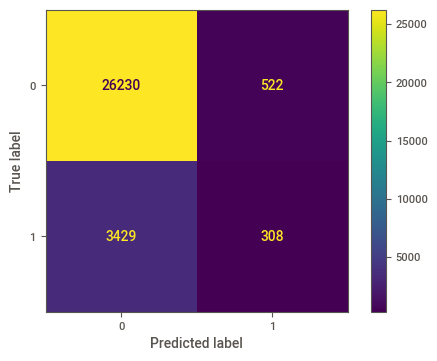

In [53]:
ConfusionMatrixDisplay.from_predictions(y_val,yhat_knn_value_predict)

In [54]:
precision_score(y_val,yhat_knn_value_predict)

0.3710843373493976

### 12.1.2 Logistic regression

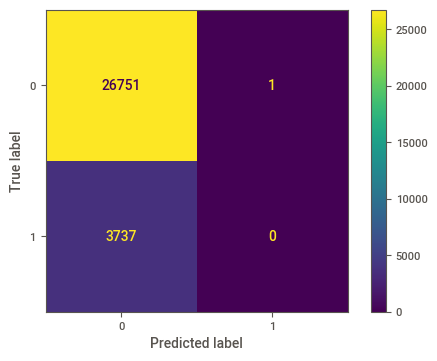

In [55]:
ConfusionMatrixDisplay.from_predictions(y_val,yhat_lr_value_predict)

In [56]:
precision_score(y_val,yhat_lr_value_predict)

0.0

The precision is not the best metric to evaluate this work, because we are not interested in classificion, but rather an ordered list of class 1 probabilities. Therefore, we must evaluate this list and not the classification model's prediction.

We should use gain and lift curves in addition to precision/recall at K.



## 12.2 Gain-lift curves and precision/recall at K

The **cumulative gains** chart shows the percentage of the overall number of cases in a given category "gained" by targeting a percentage of the total number of cases.

The **lift** chart is derived from the cumulative gains chart; the values on the y axis correspond to the ratio of the cumulative gain for each curve to the baseline

The **precision at k** is the proportion of recommended items in the top-k set that are relevant, where k is the number of rows of the sorted class 1 probability table (here represented by the dataframe "table")

The **recall at k** is the proportion of relevant items found in the top-k recommendations.

At this work, both precision and recall at k are given by the "metrics" tuple.


Source: 
- https://www.ibm.com/docs/en/spss-statistics/24.0.0?topic=overtraining-cumulative-gains-lift-charts
- https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

### 12.2.1 KNN

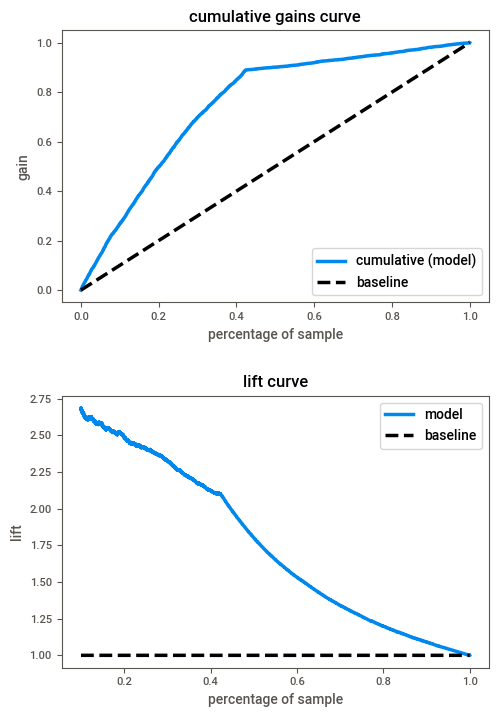

In [57]:
table = gain_lift_curve(yhat_proba_knn,y_val)

Another way to plot these curves is using the scikitplot library:

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

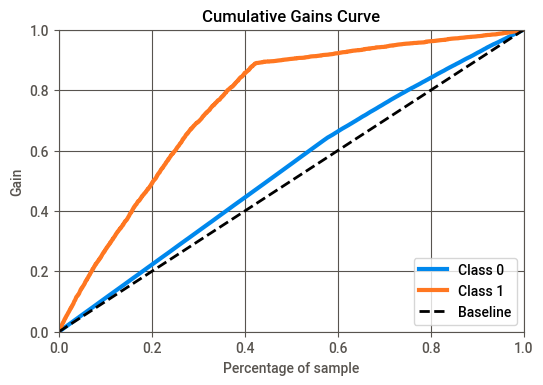

In [58]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_knn)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

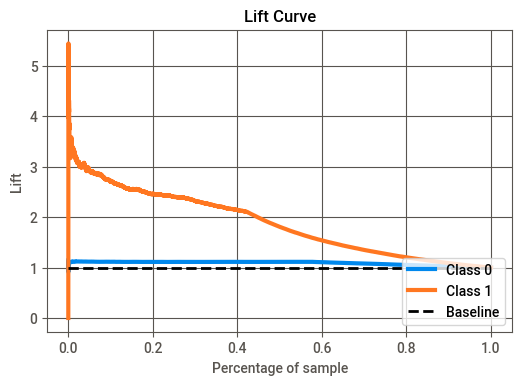

In [59]:
skplt.metrics.plot_lift_curve(y_val, yhat_proba_knn)

The variation at the start of the lift curve is due to the still small sample during the table sweep for the graph construction. This has been adjusted in the function created earlier.

In [60]:
metrics, new_table = precision_recall_at_k(table, 12200) #12200 is approximately 40% of 30489 (the validation length)
new_table

,0,1,target,correct,propensity_score,cumulative_propensity_score,cumulative_porc_base,lift,ranking,precision_at_k,recall_at_k
0,0.000,1.000,0,no,0.000000,0.000000,0.000033,0.000000,1,0.000000,0.000000
1,0.000,1.000,1,yes,0.000268,0.000268,0.000066,4.079342,2,0.500000,0.000268
2,0.000,1.000,0,no,0.000000,0.000268,0.000098,2.719561,3,0.333333,0.000268
3,0.125,0.875,0,no,0.000000,0.000268,0.000131,2.039671,4,0.250000,0.000268
4,0.125,0.875,0,no,0.000000,0.000268,0.000164,1.631737,5,0.200000,0.000268
...,...,...,...,...,...,...,...,...,...,...,...
30484,1.000,0.000,0,yes,0.000000,0.999732,0.999869,0.999864,30485,0.122552,0.999732
30485,1.000,0.000,0,yes,0.000000,0.999732,0.999902,0.999831,30486,0.122548,0.999732
30486,1.000,0.000,1,no,0.000268,1.000000,0.999934,1.000066,30487,0.122577,1.000000
30487,1.000,0.000,0,yes,0.000000,1.000000,0.999967,1.000033,30488,0.122573,1.000000


In [61]:
# at k = 12200, the max precision that can be obtained is 3737/12200 ~ 30% because there are 3737s row with class 1 target feature
display(y_val.value_counts())

print(f"\n\nKNN:\nPrecision at k: {metrics[0]}\nRecall at k: {metrics[1]}")


0    26752
1     3737
Name: response, dtype: int64



KNN:
Precision at k: 0.260327868852459
Recall at k: 0.8498795825528499


### 12.2.2 Logistic regression

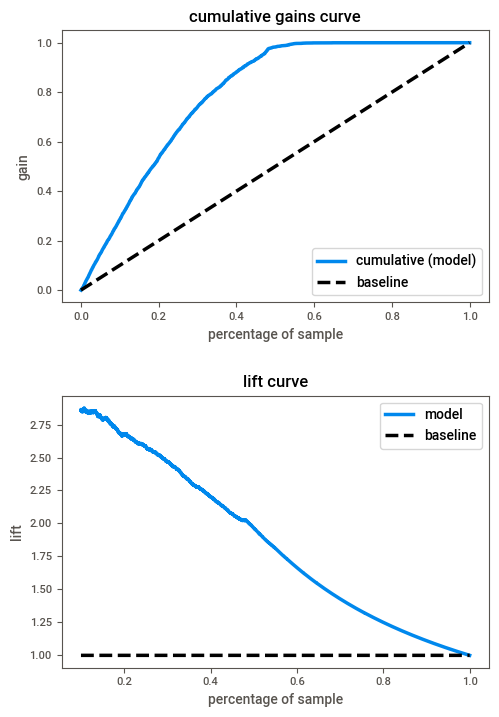

In [62]:
table = gain_lift_curve(yhat_proba_lr,y_val)

In [63]:
metrics, new_table = precision_recall_at_k(table, 12200) #12200 is approximately 40% of 30489 (the validation length)
new_table

,0,1,target,correct,propensity_score,cumulative_propensity_score,cumulative_porc_base,lift,ranking,precision_at_k,recall_at_k
0,0.428540,0.571460,0,no,0.000000,0.000000,0.000033,0.000000,1,0.000000,0.000000
1,0.501555,0.498445,1,no,0.000268,0.000268,0.000066,4.079342,2,0.500000,0.000268
2,0.511345,0.488655,0,yes,0.000000,0.000268,0.000098,2.719561,3,0.333333,0.000268
3,0.516388,0.483612,1,no,0.000268,0.000535,0.000131,4.079342,4,0.500000,0.000535
4,0.523066,0.476934,0,yes,0.000000,0.000535,0.000164,3.263473,5,0.400000,0.000535
...,...,...,...,...,...,...,...,...,...,...,...
30484,0.999718,0.000282,0,yes,0.000000,1.000000,0.999869,1.000131,30485,0.122585,1.000000
30485,0.999719,0.000281,0,yes,0.000000,1.000000,0.999902,1.000098,30486,0.122581,1.000000
30486,0.999774,0.000226,0,yes,0.000000,1.000000,0.999934,1.000066,30487,0.122577,1.000000
30487,0.999792,0.000208,0,yes,0.000000,1.000000,0.999967,1.000033,30488,0.122573,1.000000


In [64]:
# at k = 1200, the max precision that can be obtained is 3737/12200 ~ 30% because there are 3737 row with class 1 target feature
display(y_val.value_counts())

print(f"\n\nLogistic regression:\nPrecision at k: {metrics[0]}\nRecall at k: {metrics[1]}")

0    26752
1     3737
Name: response, dtype: int64



Logistic regression:
Precision at k: 0.2698360655737705
Recall at k: 0.8809205244848809


# 13. Machine learning modeling part 2

Once the metrics, gain and lift curves were set, it is time to evaluate different models. <br>
For this, it is necessary to perform cross-validation; for now let's test a cross-validation function; this function is present in a separate python file to facilitate reuse by other notebooks dedicated to different models.


In [65]:
import cross_validation as cv
cv.runCrossValidation(lr_model, x_train_df5, x_val_ml,y_train_df5,y_val, n_splits = 10, n_repeats = 2, top_k = 12200, verbose=True)

training_lenght:274398
validation_lenght:30489


Iteration number:1
(0.27524590163934426, 0.8985817500668986)

Iteration number:2
(0.2728688524590164, 0.8908215145838908)

Iteration number:3
(0.2701639344262295, 0.881990901792882)

Iteration number:4
(0.2736065573770492, 0.8932298635268933)

Iteration number:5
(0.2721311475409836, 0.8884131656408885)

Iteration number:6
(0.2721311475409836, 0.8884131656408885)

Iteration number:7
(0.27352459016393443, 0.892962269199893)

Iteration number:8
(0.270655737704918, 0.8835964677548835)

Iteration number:9
(0.2709836065573771, 0.8849036402569593)

Iteration number:10
(0.27524590163934426, 0.8988222698072805)

Iteration number:11
(0.27418032786885244, 0.8951030238158951)

Iteration number:12
(0.27385245901639343, 0.894032646507894)

Iteration number:13
(0.26852459016393443, 0.8766390152528767)

Iteration number:14
(0.27401639344262296, 0.8945678351618945)

Iteration number:15
(0.2736065573770492, 0.8932298635268933)

Iteration number:16
(0.2724

,mean,std
precision_at_k,0.272672,0.001641
recall_at_k,0.890227,0.005367


The results of cross validation is compatible with the preliminary tests presented in section 12 (specifically, for logistic regression, section 12.2.2)

 Their performance results of th different models, after tuning their hyper parameters, are presented in the next section.

# 14 Model evaluation and check point

This section is independent of the others (with the exception of section 0 - Imports and Helper Functions)

## 14.1 Load model's ranked list and interim data

In [66]:
# load model's ranked list
df_rf =  pd.read_pickle(r"../data/processed/rf_table.pkl")
df_balrf = pd.read_pickle(r"../data/processed/balrf_table.pkl")
df_lr = pd.read_pickle(r"../data/processed/lr_table.pkl")
df_knn = pd.read_pickle(r"../data/processed/knn_table.pkl")
df_xgb = pd.read_pickle(r"../data/processed/xgbclassifier_table.pkl")
df_perfect_model = pd.read_pickle(r"../data/processed/perfect_model_table.pkl")


# load interim data

##train
x_train_df5 = pd.read_pickle(r'../data/interim/x_train_df5_round1.pkl')
y_train_df5 = pd.read_pickle(r'../data/interim/y_train_df5_round1.pkl')

##validation
x_val_ml = pd.read_pickle(r'../data/interim/x_val_ml_round1.pkl')
y_val = pd.read_pickle(r'../data/interim/y_val_round1.pkl')

##test
x_test = pd.read_pickle(r'../data/interim/x_test_round1.pkl')
y_test = pd.read_pickle(r'../data/interim/y_test_round1.pkl')

cols_selected_boruta = ['age','region_code', 'policy_sales_channel', 'vehicle_damage', 'previously_insured', 
                        'annual_premium','vehicle_age_below_1_year', 'vehicle_age_between_1_2_year',
                        'vehicle_age_over_2_years', 'gender_Female', 'gender_Male']



# 14.2 Cumulative gains curves

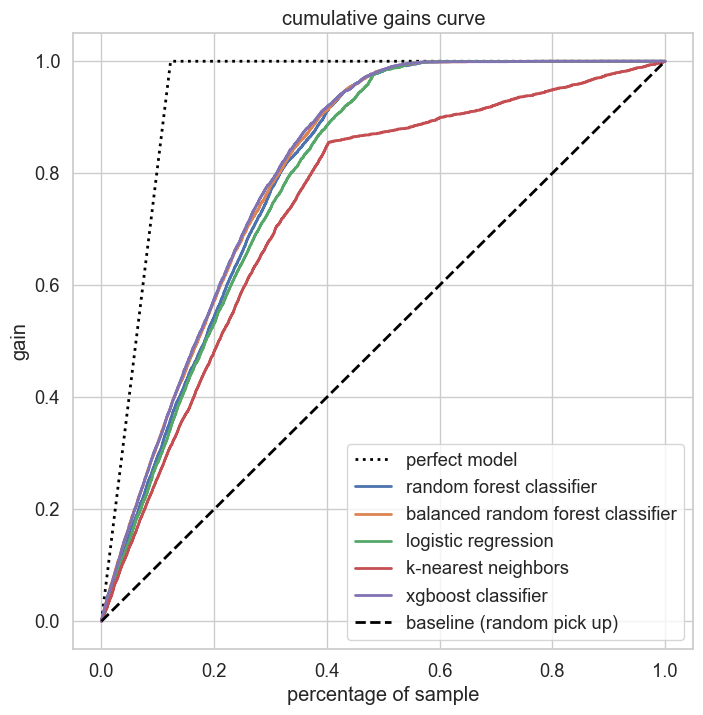

In [67]:
# restore to default matplotlib and seaborn configuration
matplotlib.rc_file_defaults()
sns.reset_orig
sns.set_theme(font_scale = 1.2, style = 'whitegrid')

# plot the graphics
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# plot the graphics
sns.lineplot(ax = axes, x = df_perfect_model['cumulative_porc_base'], y = df_perfect_model['cumulative_propensity_score'], label="perfect model", linewidth = 2, color = 'black')
sns.lineplot(ax = axes, x = df_rf['cumulative_porc_base'], y = df_rf['cumulative_propensity_score'], label="random forest classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_balrf['cumulative_porc_base'], y = df_balrf['cumulative_propensity_score'], label="balanced random forest classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_lr['cumulative_porc_base'], y = df_lr['cumulative_propensity_score'], label="logistic regression", linewidth = 2)
sns.lineplot(ax = axes, x = df_knn['cumulative_porc_base'], y = df_knn['cumulative_propensity_score'], label="k-nearest neighbors ", linewidth = 2)
sns.lineplot(ax = axes, x = df_xgb['cumulative_porc_base'], y = df_xgb['cumulative_propensity_score'], label="xgboost classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_perfect_model['cumulative_porc_base'], y = df_perfect_model['cumulative_porc_base'], label="baseline (random pick up)", linewidth = 2, color = 'black')

axes.lines[0].set_linestyle(":")
axes.lines[6].set_linestyle("--")

axes.legend()
axes.set_title("cumulative gains curve")
axes.set_xlabel("percentage of sample")
axes.set_ylabel("gain")

axes.plot;


# 14.3 Lift curves

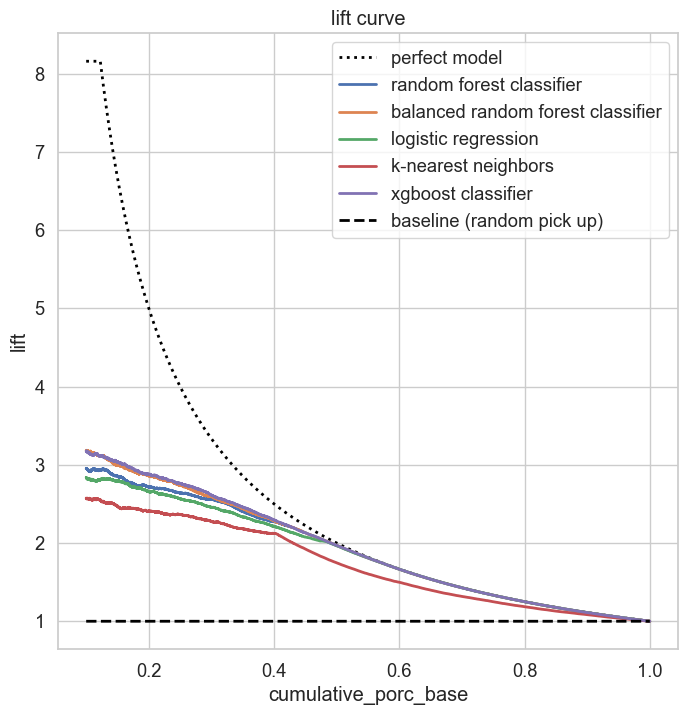

In [68]:
#sns.set()
sns.set_theme(font_scale = 1.2, style = 'whitegrid')

## do not consider the beginning of the series, as it varies a lot (the sample is still small)
df_rf_filtered = df_rf.query('cumulative_porc_base >= 0.1')
df_balrf_filtered = df_balrf.query('cumulative_porc_base >= 0.1')
df_lr_filtered = df_lr.query('cumulative_porc_base >= 0.1')
df_knn_filtered = df_knn.query('cumulative_porc_base >= 0.1')
df_xgb_filtered = df_xgb.query('cumulative_porc_base >= 0.1')
df_perfect_model_filtered = df_perfect_model.query('cumulative_porc_base >= 0.1')

# plot the graphics
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

sns.lineplot(ax = axes, x = df_perfect_model_filtered['cumulative_porc_base'], y = df_perfect_model_filtered['lift'], label="perfect model", linewidth = 2, color = 'black')
sns.lineplot(ax = axes, x = df_rf_filtered['cumulative_porc_base'], y = df_rf_filtered['lift'], label="random forest classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_balrf_filtered['cumulative_porc_base'], y = df_balrf_filtered['lift'], label="balanced random forest classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_lr_filtered['cumulative_porc_base'], y = df_lr_filtered['lift'], label="logistic regression", linewidth = 2)
sns.lineplot(ax = axes, x = df_knn_filtered['cumulative_porc_base'], y = df_knn_filtered['lift'], label="k-nearest neighbors ", linewidth = 2)
sns.lineplot(ax = axes, x = df_xgb_filtered['cumulative_porc_base'], y = df_xgb_filtered['lift'], label="xgboost classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_perfect_model_filtered['cumulative_porc_base'], y = np.ones(len(df_perfect_model_filtered)), label="baseline (random pick up)", linewidth = 2, color = 'black')

axes.lines[0].set_linestyle(":")
axes.lines[6].set_linestyle("--")

axes.legend()
axes.set_title("lift curve")

axes.plot;

# 14.4 Precision@k and recall@k of the different models

Let's evaluate the different models according to precision@k and recall@k, but this time considering different values of k.


In [69]:
print(tabulate(compiled_precision_recall(['df_knn','df_lr','df_rf','df_balrf','df_xgb','df_perfect_model'])[0], headers='keys', tablefmt='fancy_grid'))

╒══════════════╤═══════════════════════╤═══════════════════════╤════════════════════════════╤═════════════════════════════════════╤══════════════════════╤═════════════════╕
│ Precision@   │   k-nearest neighbors │   logistic regression │   random forest classifier │   balanced random forest classifier │   xgboost classifier │   perfect model │
╞══════════════╪═══════════════════════╪═══════════════════════╪════════════════════════════╪═════════════════════════════════════╪══════════════════════╪═════════════════╡
│ 10% (3049)   │                  0.32 │                  0.35 │                       0.36 │                                0.39 │                 0.39 │            1    │
├──────────────┼───────────────────────┼───────────────────────┼────────────────────────────┼─────────────────────────────────────┼──────────────────────┼─────────────────┤
│ 20% (6098)   │                  0.3  │                  0.33 │                       0.33 │                                0.35 │    

In [70]:
print(tabulate(compiled_precision_recall(['df_knn','df_lr','df_rf','df_balrf','df_xgb','df_perfect_model'])[1], headers='keys', tablefmt='fancy_grid'))

╒═════════════╤═══════════════════════╤═══════════════════════╤════════════════════════════╤═════════════════════════════════════╤══════════════════════╤═════════════════╕
│ Recall@     │   k-nearest neighbors │   logistic regression │   random forest classifier │   balanced random forest classifier │   xgboost classifier │   perfect model │
╞═════════════╪═══════════════════════╪═══════════════════════╪════════════════════════════╪═════════════════════════════════════╪══════════════════════╪═════════════════╡
│ 10% (3049)  │                  0.26 │                  0.28 │                       0.3  │                                0.32 │                 0.32 │            0.82 │
├─────────────┼───────────────────────┼───────────────────────┼────────────────────────────┼─────────────────────────────────────┼──────────────────────┼─────────────────┤
│ 20% (6098)  │                  0.48 │                  0.53 │                       0.54 │                                0.57 │          

As we can see, the xgboost classifier and balanced random forest classifier were the best models; between them, the xgboost always performed better than or equal to balanced random forest classifier. <br>
Let's train the xgboost classifier with x_train and x_val datasets and test using x_test dataset that were extracted in section #5. <br>


# 14.5 Model test

In [71]:
# unify train and validation datasets
x_train = pd.concat([x_train_df5,x_val_ml])
y_train = pd.concat([y_train_df5,y_val])


# model definition
xgbclassifier_model = XGBClassifier(n_estimators = 200,
                                    max_depth = 3,
                                    scale_pos_weight = 1,
                                    n_jobs= -1)

# model training
xgbclassifier_model.fit(x_train, y_train)

# model prediction (proba)
yhat_proba = xgbclassifier_model.predict_proba(x_test[cols_selected_boruta])


c:\users\rnfavar.embad.000\miniconda3\envs\dev_pa_4\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:35:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


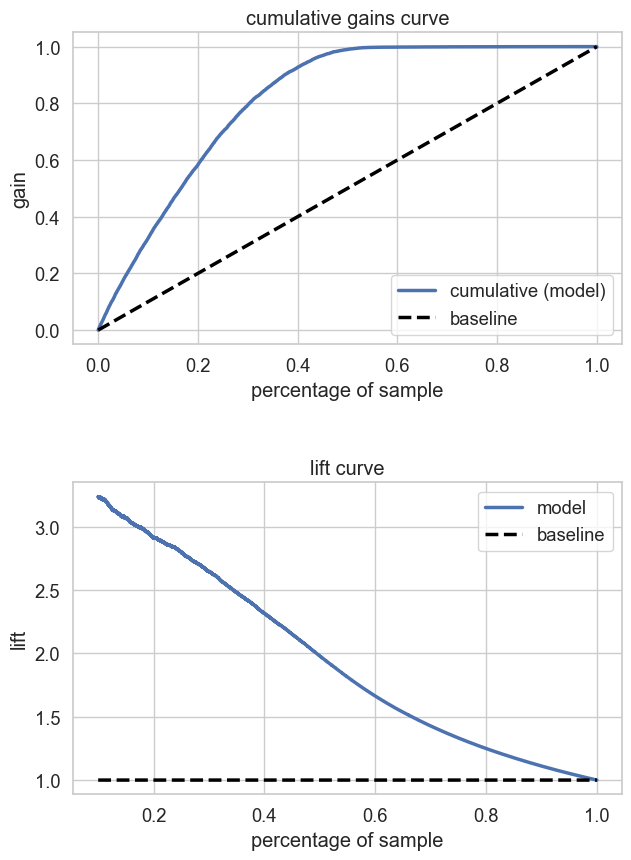

In [72]:
xgboost_test = gain_lift_curve(yhat_proba,y_test, size = (8, 10))

In [73]:
# two dictionaies, one for each metric
dict_precision = {'Precision@': ['10%' , '20%', '30%', '40%']}
dict_recall = {'Recall@': ['10%', '20%', '30%', '40%']}

# metrics (precision@k and recall@k) for 10%, 20%, 30%, 40% of the ranked list resulting from train and validation datasets
metrics10_train, _ = precision_recall_at_k(df_xgb,3049)
metrics20_train, _ = precision_recall_at_k(df_xgb,6098)
metrics30_train, _ = precision_recall_at_k(df_xgb,9147)
metrics40_train, _ = precision_recall_at_k(df_xgb,12196)

# metrics (precision@k and recall@k) for 10%, 20%, 30%, 40% of the ranked list resulting from test dataset
metrics10_test, _ = precision_recall_at_k(xgboost_test,7622)
metrics20_test, _ = precision_recall_at_k(xgboost_test,15244)
metrics30_test, _ = precision_recall_at_k(xgboost_test,22866)
metrics40_test, _ = precision_recall_at_k(xgboost_test,30488)


# construction of the two dictionaries to include 2 columns, one for each dataset, and 4 rows, one for each percentage
# train and valdation
dict_precision['xgboost classifier (train)'] = [round(metrics10_train[0], 2),
                                                round(metrics20_train[0], 2),
                                                round(metrics30_train[0], 2), 
                                                round(metrics40_train[0], 2)]
# test
dict_precision['xgboost classifier (test)'] = [round(metrics10_test[0], 2),
                                               round(metrics20_test[0], 2),
                                               round(metrics30_test[0], 2), 
                                               round(metrics40_test[0], 2)]


# train and valdation
dict_recall['xgboost classifier (train)'] = [round(metrics10_train[1], 2),
                                                round(metrics20_train[1], 2),
                                                round(metrics30_train[1], 2), 
                                                round(metrics40_train[1], 2)]
# test
dict_recall['xgboost classifier (test)'] = [round(metrics10_test[1], 2),
                                               round(metrics20_test[1], 2),
                                               round(metrics30_test[1], 2), 
                                               round(metrics40_test[1], 2)]

# convert the dictionary to dataframe
df_precision = pd.DataFrame(dict_precision).set_index('Precision@')
df_recall = pd.DataFrame(dict_recall).set_index('Recall@')



In [74]:
print(tabulate(df_precision, headers='keys', tablefmt='fancy_grid'))

╒══════════════╤══════════════════════════════╤═════════════════════════════╕
│ Precision@   │   xgboost classifier (train) │   xgboost classifier (test) │
╞══════════════╪══════════════════════════════╪═════════════════════════════╡
│ 10%          │                         0.39 │                        0.4  │
├──────────────┼──────────────────────────────┼─────────────────────────────┤
│ 20%          │                         0.35 │                        0.36 │
├──────────────┼──────────────────────────────┼─────────────────────────────┤
│ 30%          │                         0.32 │                        0.32 │
├──────────────┼──────────────────────────────┼─────────────────────────────┤
│ 40%          │                         0.28 │                        0.28 │
╘══════════════╧══════════════════════════════╧═════════════════════════════╛


In [75]:
print(tabulate(df_recall, headers='keys', tablefmt='fancy_grid'))

╒═══════════╤══════════════════════════════╤═════════════════════════════╕
│ Recall@   │   xgboost classifier (train) │   xgboost classifier (test) │
╞═══════════╪══════════════════════════════╪═════════════════════════════╡
│ 10%       │                         0.32 │                        0.32 │
├───────────┼──────────────────────────────┼─────────────────────────────┤
│ 20%       │                         0.58 │                        0.58 │
├───────────┼──────────────────────────────┼─────────────────────────────┤
│ 30%       │                         0.78 │                        0.79 │
├───────────┼──────────────────────────────┼─────────────────────────────┤
│ 40%       │                         0.92 │                        0.93 │
╘═══════════╧══════════════════════════════╧═════════════════════════════╛


After training the model with the training and validation datasets and testing it with new data (which were not previously used in the training and cross-validation of the different models), it is observed that the model continued to perform very well, with similar metric values obtained previously.

Therefore, the xgboost classifier model will be trained with all available data and put into production.



# 15. Deploy to production

## 15.1. Unify train and test datasets

In [76]:
X = pd.concat([x_train, x_test[cols_selected_boruta]])
y = pd.concat([y_train, y_test])

## 15.2 Final model

In [77]:
# model definition (the same hyperparameters after fine tuning)
xgbclassifier_model = XGBClassifier(n_estimators = 200,
                                    max_depth = 3,
                                    scale_pos_weight = 1,
                                    n_jobs= -1)

# model training
xgbclassifier_model.fit(X, y)

c:\users\rnfavar.embad.000\miniconda3\envs\dev_pa_4\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:44:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
## save the model
pickle.dump(xgbclassifier_model, open(r'../models/xgbclassifier_model.pkl', 'wb'))


## 15.3 Class HealthInsurance

This class was created to be the pipeline of the model in production, containing all the necessary steps (data cleaning, feature engineering and data preparation) to perform the prediction probabilities.

The solution was deployed on Heroku: url = 'https://health-insurance-cross-sell-pr.herokuapp.com/healthinsurance/predict'

In [ ]:
import pickle
import numpy as np
import pandas as pd

class HealthInsurance:
    def __init__(self):
        
        # annual premium
        self.annual_premium_scaler = pickle.load(open('features/annual_premium_scaler.pkl', 'rb'))
        
        # age scaler
        self.age_scaler = pickle.load(open('features/age_scaler.pkl', 'rb'))
        
        # region code
        self.target_encode_region_code_scaler = pickle.load(open('features/target_encode_region_code_scaler.pkl', 'rb'))
        
        # policy sales channel
        self.fe_policy_sales_channel_scaler = pickle.load(open('features/fe_policy_sales_channel_scaler.pkl', 'rb'))
        
        # vintage
        # this feature was not chosen
        
   
    def data_cleaning(self, df1):
        #columns_name = ['id', 'gender', 'age', 'region_code', 'policy_sales_channel','driving_license', 
        #                'vehicle_age', 'vehicle_damage','previously_insured', 'annual_premium', 'vintage']
        
        columns_name = ['id', 'gender', 'age', 'driving_license','region_code','previously_insured',
                        'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage']
        
        
        
        df1.columns = columns_name
        
        return df1
        
        
        
    def feature_engineering (self, df2):
        
        # vehicle damage
        dict_vehicle_damage = {'Yes': 1, 'No': 0}
        df2['vehicle_damage'] = df2['vehicle_damage'].map(dict_vehicle_damage)
        
        # vehicle_age
        dict_vehicle_age = {'> 2 Years':'over_2_years', '1-2 Year':'between_1_2_year', '< 1 Year':'below_1_year'}
        df2['vehicle_age'] = df2['vehicle_age'].map(dict_vehicle_age)
        
        return df2
        
    def data_preparation (self, df3):
        
        # annual_premium
        df3['annual_premium'] = self.annual_premium_scaler.transform(df3[['annual_premium']].values)

        # age
        df3['age'] = self.age_scaler.transform(df3[['age']].values)

        # region_code
        df3['region_code'] = df3['region_code'].map(self.target_encode_region_code_scaler)

        # policy_sales_channel
        df3['policy_sales_channel'] = df3['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)
        
        # vehicle_age
        df3 = pd.get_dummies(df3, prefix='vehicle_age', columns = ['vehicle_age'])
        
        
        # I'm assuming there is no unseen data by encoder; in case there is (as it happened during section 9.4, I should use something like this)
        # i='browser'
        # le = LabelEncoder()
        # train[i] = le.fit_transform(train[i])
        ## Set classes in test which don't exist in the encoder to -1
        # test.loc[~test[i].isin(le.classes_),i] = -1    
        ## Encode classes that exist in the encoder
        #test.loc[test[i].isin(le.classes_),i] = le.transform(test[i][test[i].isin(le.classes_)])
        
        # gender
        df3 = pd.get_dummies(df3, prefix='gender', columns = ['gender'])
        
        # vintage
        # this feature was not chosen
        
        # as gender and age are derived in multiple columns (due to pandas get_dummies method) it is necessary to perform a check:

        if "gender_Male" not in df3.columns:
            df3["gender_Male"] = 0
        
        if "gender_Female" not in df3.columns:
            df3["gender_Female"] = 0
            
        if "vehicle_age_below_1_year" not in df3.columns:
            df3["vehicle_age_below_1_year"] = 0
        
        if "vehicle_age_between_1_2_year" not in df3.columns:
            df3["vehicle_age_between_1_2_year"] = 0
        
        if "vehicle_age_over_2_years" not in df3.columns:
            df3["vehicle_age_over_2_years"] = 0
        
        cols_selected_boruta = ['age','region_code', 'policy_sales_channel', 'vehicle_damage', 'previously_insured', 
                                'annual_premium','vehicle_age_below_1_year', 'vehicle_age_between_1_2_year',
                                'vehicle_age_over_2_years', 'gender_Female', 'gender_Male']
            
        return df3[cols_selected_boruta]
    
    def get_prediction(self, model, original_data, test_data):
        
        # model prediciton
        pred = model.predict_proba(test_data)
        
        # creating a prediction dataframe of the predict_proba (class 0 and 1 predictions)
        table_proba = pd.DataFrame(pred)
        
        # join prediction into original data
        original_data['Score'] = table_proba[1]
        
        original_data.sort_values('Score', ascending = False, inplace = True)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')

## 15.4 API Handler

This is also part of the deployed solution. This is the API handler which will consume the previously created class.

In [ ]:
import pickle
import os
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.healthinsurance import HealthInsurance

# load model
model = pickle.load(open('models/xgbclassifier_model.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/healthinsurance/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict): #unique row
            test_raw = pd.DataFrame(test_json, index = [0])
        
        else: # multiple rows
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
        
        test_raw_copy = test_raw.copy()
        
        # instantiate HealthInsurance class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        print('apos df1')
        print(test_raw.head())
        print(test_raw.head().values)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        print('apos df2')
        print(test_raw.head())
        print(test_raw.head().values)

        # data preparation
        df3 = pipeline.data_preparation(df2)
        print('apos df3')
        print(test_raw.head())
        print(test_raw.head().values)
           
        # prediction    
        df_response = pipeline.get_prediction(model, test_raw_copy, df3)
        
        return df_response
    
    else:
        return Response('{}', status = 200, mimetype = 'application/json')
    
if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run('0.0.0.0', port=port)

## 15.5 API Tester

The following script tests the deployed solution using a totally new dataset, which we don't have the answer, so it is not possible to plot the gain and lift curves.

In [1]:
import requests
import json
import pandas as pd

# loading dataset
df_test = pd.read_csv(r'../data/raw/test.csv')
data = json.dumps(df_test.to_dict(orient = 'records'))

In [2]:
df_test

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297
...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,Female,26,1,37.0,1,< 1 Year,No,30867.0,152.0,56
127033,508143,Female,38,1,28.0,0,1-2 Year,Yes,28700.0,122.0,165
127034,508144,Male,21,1,46.0,1,< 1 Year,No,29802.0,152.0,74
127035,508145,Male,71,1,28.0,1,1-2 Year,No,62875.0,26.0,265


This new dataset can be seen below.

And now we can predict and order according to the probability of customers purchasing auto insurance (columns 'Score').
It is expected that the performance of this list will be similar to that presented in the test base (section 

In [3]:
# API Call
url = 'https://health-insurance-cross-sell-pr.herokuapp.com/healthinsurance/predict'
header = {'Content-type':'application/json'}
r = requests.post(url,data,headers=header)
print('Status code {}'.format(r.status_code))

Status code 200


In [4]:
returned_df = pd.DataFrame(r.json())
returned_df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Score
0,483021,Male,48,1,28.0,0,< 1 Year,Yes,148945.0,26.0,161,0.838134
1,505301,Female,52,1,28.0,0,< 1 Year,Yes,68543.0,26.0,80,0.809880
2,395476,Male,57,1,28.0,0,< 1 Year,Yes,51231.0,26.0,24,0.769510
3,463662,Male,56,1,28.0,0,< 1 Year,Yes,52102.0,26.0,40,0.767470
4,393762,Male,50,1,28.0,0,> 2 Years,Yes,130474.0,26.0,49,0.741157
...,...,...,...,...,...,...,...,...,...,...,...,...
127032,400793,Male,76,1,50.0,1,1-2 Year,No,37770.0,65.0,298,0.000044
127033,409640,Male,65,1,9.0,1,1-2 Year,No,49501.0,152.0,195,0.000044
127034,400127,Female,62,1,33.0,1,1-2 Year,No,62386.0,152.0,265,0.000044
127035,485162,Female,66,1,8.0,1,1-2 Year,No,71800.0,152.0,79,0.000043


# 16. Further considerations

For future learning to rank problems or new CRISP rounds, consider training these models:
- Balanced Bagging Classifier;
- Easy Ensemble Classifier;
- Random Under Sampler Classifier;
- Stochastic Gradient Descent Classifier;